In [1]:
import cv2
import numpy as np
from pathlib import Path
from boxmot import DeepOCSORT, StrongSORT, BoTSORT
from ultralytics import YOLO
from pathlib import Path

In [2]:
def initialize_tracker(model_weights, device='cuda:0', fp16=True):
    """
    Initialize the DeepOCSORT tracker with the given model weights and device.
    """
    tracker = BoTSORT(
        model_weights=model_weights,
        device=device,
        fp16=fp16
    )
    return tracker

def initialize_yolo(model_path):
    """
    Initialize the YOLO object detector with the given model path.
    """
    yolov8 = YOLO(model_path)
    return yolov8

In [3]:
class Rect:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
    
    @property
    def bottom_center(self):
        return ((self.x1 + self.x2) // 2, self.y2)
    
    @property
    def width(self):
        return self.x2 - self.x1

class Color:
    def __init__(self, b, g, r):
        self.b = b
        self.g = g
        self.r = r

    @property
    def bgr_tuple(self):
        return (self.b, self.g, self.r)

def draw_ellipse(image, rect, color, thickness=2):
    center = rect.bottom_center
    axes = (int(rect.width), int(0.35 * rect.width))
    cv2.ellipse(
        image,
        center,
        axes,
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color.bgr_tuple,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
    return image

def lab_to_rgb(lab_color):
    """
    Converts a single LAB color to RGB.
    """
    lab_image = np.array([[lab_color]], dtype=np.uint8)
    rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_Lab2RGB)
    return rgb_image[0][0]

def create_new_file(file_name):
    """
    Check if a file already exists, if it does append a number to the file
    The number increases if a file_"number" exists
    """
    if Path(file_name).is_file():
        file = file_name.split(".")[0]
        extension = file_name.split(".")[1]
        last_char = file[len(file) - 1]
        if last_char.isnumeric():
            last_char = str(int(last_char) + 1)
            new_file =  file[:-1] + last_char + "." + extension
        else:
            last_char = "_1"
            new_file =  file + last_char + "." + extension
        
        return create_new_file(new_file)
    else:
        return file_name

In [4]:
def plot_kmeans_clusters(player_mean_colors, labels):
    player_mean_colors = np.array([lab_to_rgb(color) for color in player_mean_colors])

    # Plotting the results (optional)
    plt.subplot(1, 2, 1)
    plt.scatter(player_mean_colors[:, 1], player_mean_colors[:, 2], c=player_mean_colors / 255.0)
    plt.title('Original Colors')

    plt.subplot(1, 2, 2)
    plt.scatter(player_mean_colors[labels == 0][:, 1], player_mean_colors[labels == 0][:, 2], c='blue', marker='o')
    plt.scatter(player_mean_colors[labels == 1][:, 1], player_mean_colors[labels == 1][:, 2], c='red', marker='x')
    plt.title('Clustered Colors')

    plt.show()
    
def home_away_color_ranges(home, away):
    # plot_lab_region(home[0], home[1])
    plot_lab_region(away[0], away[1])

    plt.figure(figsize=(10, 5))

    # Displaying the mask
    plt.subplot(1, 4, 1)
     # Plotting the most common color
    plt.imshow(cv2.cvtColor(home[0][np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Home Lower")

    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(home[1][np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Home Upper")

    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(away[0][np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Away Lower")

    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(away[1][np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Away Upper")

    plt.show()

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sys
import sklearn
from collections import Counter


def adjust_bbox(image, bbox, height_fraction=(0.17, 0.5), width_fraction=(0.2, 0.2)):
    x1, y1, x2, y2 = bbox
    
    # Adjusting the bounding box to focus on the upper part
    height = y2 - y1
    width = x2 - x1
    
    new_y1 = y1 + int(height_fraction[0] * height)
    new_y2 = y1 + int(height_fraction[1] * height)
    new_x1 = x1 + int(width_fraction[0] * width)
    new_x2 = x2 - int(width_fraction[1] * width)

    adjusted_bbox = (new_x1, new_y1, new_x2, new_y2)
    roi = image[adjusted_bbox[1]:adjusted_bbox[3], adjusted_bbox[0]:adjusted_bbox[2]]

    return roi

def filter_out_color_LAB(roi_lab, lower_treshold, upper_treshold):
    # Getting the A channel and applying threshold
    a_channel = roi_lab[:,:,1]
    #127, 255
    _, mask = cv2.threshold(a_channel, lower_treshold, upper_treshold, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Using the mask to exclude green pixels in LAB
    roi_lab_filtered = roi_lab.copy()
    roi_lab_filtered[mask != 255] = 0
    return roi_lab_filtered

def get_color_histogram(image, bbox):
    """
    Get the color histogram within a specific portion of the bounding box in the HSV color space.
    """
    roi = adjust_bbox(image, bbox)
    # Converting to LAB color space
    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
    roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
    
    non_black_pixels = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
    color_counter = Counter(map(tuple, non_black_pixels))
    most_common_color = color_counter.most_common(1)[0][0]
        
    non_zero_subarrays = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
    
    hist = cv2.calcHist([roi_lab], [0, 1], None, [8, 8], [0, 180, 0, 256])
    
    cv2.normalize(hist, hist)
    
    return hist.flatten()

def get_mean_color(image, bbox):
    """
    Get the mean color within a specific portion of the bounding box in both RGB and LAB color spaces,
    excluding green pixels.
    """
    roi = adjust_bbox(image, bbox)

    # Converting to LAB color space
    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
    roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
        
    non_zero_subarrays = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]

    # Calculate the mean of each channel
    if non_zero_subarrays.size > 0:
        mean_color_lab = non_zero_subarrays.mean(axis=0)
        
        
    color_counter = Counter(map(tuple, non_zero_subarrays))
    most_common_color_lab = np.array(color_counter.most_common(1)[0][0], dtype=np.uint8)

    most_common_color_bgr = cv2.cvtColor(np.array([[most_common_color_lab]], dtype=np.uint8), cv2.COLOR_Lab2BGR)[0][0]
    mean_color_bgr = cv2.cvtColor(np.array([[mean_color_lab]], dtype=np.uint8), cv2.COLOR_Lab2BGR)[0][0]
    return most_common_color_lab, mean_color_lab

def perform_kmeans_clustering(colors, initial_centroids, color_multiplier=4, max_iter=10, n_clusters=2):
    """
    Perform k-means clustering on the given color data.
    """
    colors = np.array(colors)
    
    colors[:,1:3] *= 4
    if len(initial_centroids) != 0:
        kmeans = KMeans(n_clusters=2, init=initial_centroids, random_state=0, n_init=1, max_iter=max_iter).fit(colors)
    else:
        kmeans = KMeans(n_clusters=2, random_state=0).fit(colors)
        initial_centroids = kmeans.cluster_centers_
        
    # Reassign labels based on the order of centroids
    sorted_idx = np.argsort(initial_centroids[:, 0])  # Assuming the 0th feature is a color channel like Red
    mapping = np.zeros(n_clusters, dtype=int)
    for i, idx in enumerate(sorted_idx):
        mapping[idx] = i

    consistent_labels = mapping[kmeans.labels_]
    
    return consistent_labels, initial_centroids

In [6]:
from scipy.spatial import distance
from scipy import stats
    
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection



def plot_filtered_boxes(frame, boxes):
    plt.figure(figsize=(12, len(boxes) * 4))
    
    for i, box in enumerate(boxes):
        # Apply the ROI adjustment and color filtering
        roi = adjust_bbox(frame, box)
        roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
        roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
        non_zero_colors = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]

        plt.subplot(len(boxes), 2, i * 2 + 1)
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Box {i+1}")

        plt.subplot(len(boxes), 2, i * 2 + 2)
        plt.imshow(cv2.cvtColor(roi_lab_filtered, cv2.COLOR_Lab2RGB))
        plt.title(f"Filtered Box {i+1}")
        
    plt.show()

def compute_common_color_cluster_and_range(frame, boxes, num_clusters=2, delta=10):
    colors = []
    for box in boxes:
        roi = adjust_bbox(frame, box)
        roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
        roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
        non_zero_colors = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
        colors.extend(non_zero_colors)

    if len(colors) == 0:
        print("All colors are filtered out.")
        return None, None

    # Applying K-means clustering to group colors
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(colors)
    cluster_centers = kmeans.cluster_centers_.astype(int)

    # Getting the most common cluster center (centroid)
    labels, counts = np.unique(kmeans.labels_, return_counts=True)
    most_common_cluster = cluster_centers[labels[np.argmax(counts)]]

    # Compute the color range
    lower_bound = np.clip(most_common_cluster - delta, 0, 255)
    upper_bound = np.clip(most_common_cluster + delta, 0, 255)

    # Plotting the most common color cluster center
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(most_common_cluster[np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Most Common Cluster Center")
    plt.axis('off')

    # Plotting colors within the range
    plt.subplot(1, 2, 2)
    for i in range(5):
        sample_color = np.random.randint(lower_bound, upper_bound+1)
        plt.imshow(cv2.cvtColor(sample_color[np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
        plt.title("Colors Within Range")
        plt.axis('off')

    plt.show()

    return lower_bound, upper_bound    
    
def compute_common_color_and_range(frame, boxes, delta=10):
    colors = []
    for box in boxes:
        roi = adjust_bbox(frame, box)
        roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
        roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
        non_zero_colors = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
        colors.extend(non_zero_colors)

    if len(colors) == 0:
        print("All colors are filtered out.")
        return None, None

    color_counter = Counter(map(tuple, colors))
    most_common_color = np.array(color_counter.most_common(1)[0][0], dtype=np.uint8)

    # Compute the color range
    lower_bound = most_common_color - delta
    upper_bound = most_common_color + delta
    
    # Ensure the bounds are valid
    if np.any(upper_bound < lower_bound):
        print("Invalid color range corrected.")
        lower_bound = most_common_color
        upper_bound = most_common_color
    
    lower_bound = np.clip(lower_bound, 0, 255)
    upper_bound = np.clip(upper_bound, 0, 255)

    # Plotting the most common color
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(most_common_color[np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Most Common Color")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    for i in range(5):
        sample_color = np.random.randint(lower_bound, upper_bound + 1, size=(1,1,3))
        plt.imshow(cv2.cvtColor(sample_color.astype(np.uint8), cv2.COLOR_Lab2RGB))
        plt.axis('off')

    return lower_bound, upper_bound


def nearest_points(centroids, data_points, n):
    # Calculate the distances between each data point and each centroid
    distances = distance.cdist(data_points, centroids, 'euclidean')
    
    # Get the n smallest distances' indices for each centroid
    nearest_indices = np.argsort(distances, axis=0)[:n]
    
    # Creating a dictionary to hold the indices of the nearest points for each centroid
    nearest_per_centroid = {i: nearest_indices[:, i].tolist() for i in range(centroids.shape[0])}

    return nearest_per_centroid


def compute_jersey_colors(first_frame, dets, bounding_boxes, classes, color_multiplier=4):
    # get_mean_color returns a tuple, 0 is most common color, 1 is mean color
    class_1_boxes = [bounding_box for bounding_box, cls in zip(bounding_boxes, classes) if cls == 1]
    colors_bounding_boxes = [(get_mean_color(first_frame, bounding_box)[1], bounding_box) for bounding_box in class_1_boxes]
    
    mean_colors = []
    for color_bbox in colors_bounding_boxes:
        mean_colors.append(color_bbox[0])
    
    initial_centroids = []
    mean_colors = np.array(mean_colors)
    label_clusters, centroids = perform_kmeans_clustering(mean_colors, initial_centroids, color_multiplier=color_multiplier)
    clustered_points = mean_colors.copy()
    clustered_points[:,1:3] *= color_multiplier
    
    close_points = nearest_points(centroids, clustered_points, 4)
    
    centroid_1_boxes = [class_1_boxes[i] for i in close_points[0]]
    centroid_2_boxes = [class_1_boxes[i] for i in close_points[1]]
    
    
    #plot_filtered_boxes(first_frame, centroid_1_boxes)
    #plot_filtered_boxes(first_frame, centroid_2_boxes)
    print("first")
    home1 = compute_common_color_cluster_and_range(first_frame, centroid_1_boxes)
    home = compute_common_color_and_range(first_frame, centroid_1_boxes)

    print("second")
    away1 = compute_common_color_cluster_and_range(first_frame, centroid_2_boxes)
    away = compute_common_color_and_range(first_frame, centroid_2_boxes)


    print("Most Dominant Color (in LAB):", away1)
    return (home, away)
    

def plot_lab_region(lower_bound, upper_bound):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Define the vertices of the region
    # Each vertex is a combination of the lower and upper values for L, a, and b
    vertices = [
        [lower_bound[0], lower_bound[1], lower_bound[2]],
        [upper_bound[0], lower_bound[1], lower_bound[2]],
        [upper_bound[0], upper_bound[1], lower_bound[2]],
        [lower_bound[0], upper_bound[1], lower_bound[2]],
        [lower_bound[0], lower_bound[1], upper_bound[2]],
        [upper_bound[0], lower_bound[1], upper_bound[2]],
        [upper_bound[0], upper_bound[1], upper_bound[2]],
        [lower_bound[0], upper_bound[1], upper_bound[2]]
    ]
    
    vertices = np.array(vertices)
    
    # Define the vertices that compose each of the 6 faces of the region
    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],
        [vertices[4], vertices[5], vertices[6], vertices[7]], 
        [vertices[0], vertices[1], vertices[5], vertices[4]], 
        [vertices[1], vertices[2], vertices[6], vertices[5]],
        [vertices[2], vertices[3], vertices[7], vertices[6]],
        [vertices[3], vertices[0], vertices[4], vertices[7]]
    ]
    
    # Draw the faces
    ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolors='black', alpha=.25))
    
    ax.set_xlabel('L*')
    ax.set_ylabel('a*')
    ax.set_zlabel('b*')
    ax.set_xlim([0, 255])
    ax.set_ylim([-255, 255])
    ax.set_zlim([-255, 255])
    plt.show()

        
def get_team_belonging(image, bounding_box, home_color, away_color, should_plot=False):
    #blur_kernel_size = (2,2)
    #image = cv2.blur(image, blur_kernel_size)
    roi = adjust_bbox(image, bounding_box)
    
    # Converting to LAB color space
    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
    
    roi_lab_away = roi_lab.copy()
    roi_lab_referee = roi_lab.copy()
    
    lower_blue = np.array([100, 50, 50])
    upper_blue = np.array([140, 255, 255])
    
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 50, 255])
    
    
    mask_home = cv2.inRange(roi_lab, home_color[0], home_color[1])
    #mask_home = cv2.inRange(roi_lab, lower_blue, upper_blue)
    result_home = cv2.bitwise_and(roi_lab, roi_lab, mask=mask_home)
    count_home = cv2.countNonZero(mask_home)
    
    mask_away = cv2.inRange(roi_lab_away, away_color[0], away_color[1])
    #mask_away = cv2.inRange(roi_lab_away, lower_white, upper_white)
    result_away = cv2.bitwise_and(roi_lab_away, roi_lab_away, mask=mask_away)
    count_away = cv2.countNonZero(mask_away)
    
    if should_plot:
        plt.figure(figsize=(10, 5))
        # Displaying the mask
        plt.subplot(1, 5, 1)
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title("Result")

        plt.subplot(1, 5, 2)
        plt.imshow(mask_home, cmap='gray')
        plt.title("Mask Home")

        # Displaying the result
        plt.subplot(1, 5, 3)
        plt.imshow(cv2.cvtColor(result_home, cv2.COLOR_HSV2RGB))
        plt.title("Result Home")

        plt.subplot(1, 5, 4)
        plt.imshow(mask_away, cmap='gray')
        plt.title("Mask Away")

        # Displaying the result
        plt.subplot(1, 5, 5)
        plt.imshow(cv2.cvtColor(result_away, cv2.COLOR_HSV2RGB))
        plt.title("Result Away")

        plt.show()
        
        
    team = -1
    
    if count_away > count_home:
        team = 1
        print("Away team")
    else:
        print("Home team")
        team = 0
        
    return team

In [7]:
import os
import cv2
import zipfile

# Function to get unique colors for each class id
def get_color(cls_id):
    np.random.seed(cls_id)
    return tuple(np.random.randint(0, 255, 3).tolist())

def split_ball_players(detections):
    dets = []
    ball = np.array([])
    highest_conf = 0

    for bounding_boxes in detections:
        if bounding_boxes[-1:] != 0:
            dets.append(bounding_boxes)
        if bounding_boxes[5] == 0:
            if bounding_boxes[4] > highest_conf:
                highest_conf = bounding_boxes[4]
                ball = bounding_boxes


    dets = np.array(dets)
    
    return dets, ball

def draw_on_frame(image, xyxys, ids, clss, labels, ball):
    thickness = 2
    fontscale = 0.5

    
    for xyxy, id, cls, label in zip(xyxys, ids, clss, labels):


        # Convert bounding box coordinates to Rect object
        rect = Rect(xyxy[0], xyxy[1], xyxy[2], xyxy[3])
        if cls == 1:
            cls = cls + label

        # Get a unique color for each class
        color = Color(*get_color(cls))

        # Draw an ellipse at the bottom of the bounding box
        draw_ellipse(image, rect, color, thickness)

        # Place ID text just above the ellipse
        cv2.putText(
            image,
            f'{id}',
            (rect.bottom_center[0] - 10, rect.bottom_center[1] - int(0.35 * rect.width) - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontscale,
            color.bgr_tuple,
            thickness
        )
    if len(ball) != 0:
        rect = Rect(int(ball[0]), int(ball[1]), int(ball[2]), int(ball[3]))
        # Get a unique color for each class
        color = Color(*get_color(0))

        # Draw an ellipse at the bottom of the bounding box
        draw_ellipse(image, rect, color, thickness)
        id = -1
        # Place ID text just above the ellipse
        cv2.putText(
            image,
            "-1",
            (rect.bottom_center[0] - 10, rect.bottom_center[1] - int(0.35 * rect.width) - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontscale,
            color.bgr_tuple,
            thickness
        )
        
        
def save_frame_as_image(frame, output_folder, frame_id):
    """Save the current frame as an image."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    filename = os.path.join(output_folder, f"{frame_id:06}.jpg")
    print("Saved: " + filename)
    cv2.imwrite(filename, frame)

def write_labels_txt(class_names, filepath):
    """Write class names to labels.txt."""
    with open(filepath, "w") as f:
        for name in class_names:
            f.write(name + "\n")

def export_to_mot_format(frames, track_ids, bboxes, class_ids, filepath):
    """Write the tracking results into gt.txt in the MOT format."""
    with open(filepath, 'w') as f:
        for frame_num, track_id, bbox, class_id in zip(frames, track_ids, bboxes, class_ids):
            x1, y1, x2, y2 = bbox
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            w = x2 - x1
            h = y2 - y1
            f.write(f"{frame_num},{track_id},{x1},{y1},{w},{h},1,{class_id},0.86014\n")


In [8]:
def process_video(input_file, output_file, tracker, yolov8, do_kmeans, conf=0.3, should_plot=False, class_names=None):
    """
    Process the input video, perform object detection and tracking, and save the results to the output video.
    """
    input_video = cv2.VideoCapture(input_file)
    width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = input_video.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))
  
    # Directories for the MOT structure
    temp_folder = "temp_task_folder"
    img_folder = os.path.join(temp_folder, "img1")
    gt_folder = os.path.join(temp_folder, "gt")
    
    frames = []
    track_ids = []
    bboxes = []
    scores = []
    class_ids = []

    initial_centroids = []
    counter = 1
    while True:
        print(counter)
        ret, image = input_video.read()
        if not ret:
            break
        
        # Save the frame as image for the MOT structure
        save_frame_as_image(image, img_folder, counter)
        
        predicted = yolov8.predict(image, conf=conf)
        detections = predicted[0].boxes.data.cpu().numpy()
        
        # Split the ball detections and player detections into two arrays
        # This ensures the labels are correct when doing team assignment
        # and that we only get 1 ball in each frame
        dets, ball = split_ball_players(detections)
        
        tracks = tracker.update(dets, image)
        
        # Set im = image so we can do transforms on the image for better color identification
        # Without altering the original image so when writing the video it looks the same
        #im = cv2.addWeighted(image, 0.75, image, 0.5, 0)
        im = image
        
        if tracks.size > 0:  # Check if tracks is not empty
            xyxys = tracks[:, 0:4].astype('int')
            ids = tracks[:, 4].astype('int')
            clss = tracks[:, 6].astype('int')
        else:
            print("Tracks is empty or not in expected format.")

        if(counter == 1):
            home, away = compute_jersey_colors(im, dets, xyxys, clss)
            
            if should_plot:
                home_away_color_ranges(home, away)
            
            
        if tracks.shape[0] != 0:
            player_mean_colors = [get_mean_color(im, xyxy)[1] for xyxy, cls in zip(xyxys, clss) if cls == 1]
            #player_mean_colors = [get_color_histogram(im, xyxy) for xyxy, cls in zip(xyxys, clss) if cls == 1]
            
            if(len(initial_centroids) == 0):
                labels, initial_centroids = perform_kmeans_clustering(player_mean_colors, initial_centroids)

            else:
                if do_kmeans:
                    labels = perform_kmeans_clustering(player_mean_colors, initial_centroids)[0]
                else:
                    labels = [get_team_belonging(im, xyxy, home, away) for xyxy, cls in zip(xyxys, clss) if cls == 1]
            
            if should_plot:
                plot_kmeans_clusters(player_mean_colors, labels)   
    
    
            draw_on_frame(image, xyxys, ids, clss, labels, ball)
                
             # Collect data for MOT format
            for track in tracks:
                frames.append(counter)
                track_ids.append(int(track[4]))
                bboxes.append(track[0:4])
                class_ids.append(int(track[6]))
        if len(ball) != 0:        
            frames.append(counter)
            track_ids.append(30)
            bboxes.append(ball[0:4])
            class_ids.append(int(ball[5]))

        out.write(image)
        counter += 1
        
    # Once the video is processed, generate the MOT structure
    # Write class names into labels.txt
    labels_txt_path = os.path.join(gt_folder, "labels.txt")
    os.makedirs(os.path.dirname(labels_txt_path), exist_ok=True)
    write_labels_txt(class_names, labels_txt_path)

    # Write tracking results into gt.txt
    gt_txt_path = os.path.join(gt_folder, "gt.txt")
    export_to_mot_format(frames, track_ids, bboxes, class_ids, gt_txt_path)

    # Zip everything
    output_zip_path = os.path.splitext(output_file)[0] + ".zip"
    with zipfile.ZipFile(output_zip_path, 'w') as zipf:
        for foldername, subfolders, filenames in os.walk(temp_folder):
            for filename in filenames:
                filepath = os.path.join(foldername, filename)
                zipf.write(filepath)
  
    input_video.release()
    out.release()
    cv2.destroyAllWindows()

    for foldername, subfolders, filenames in os.walk(temp_folder, topdown=False):
        for filename in filenames:
            os.remove(os.path.join(foldername, filename))
        os.rmdir(foldername)

Tracking output: videos/1min_Bodø_start_tracking_output_test.mp4


2023-11-03 13:23:52.643 | SUCCESS  | boxmot.appearance.reid_model_factory:load_pretrained_weights:207 - Successfully loaded pretrained weights from "osnet_x1_0_market1501.pt"


1
Saved: temp_task_folder/img1/000001.jpg



0: 1088x1920 1 ball, 22 players, 125.8ms
Speed: 34.3ms preprocess, 125.8ms inference, 144.9ms postprocess per image at shape (1, 3, 1088, 1920)


first


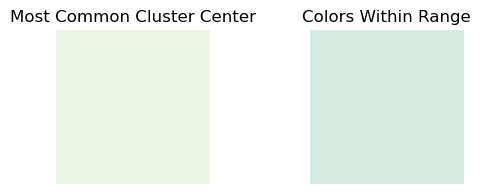

Invalid color range corrected.
second


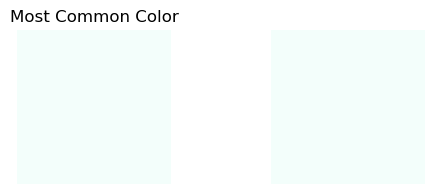

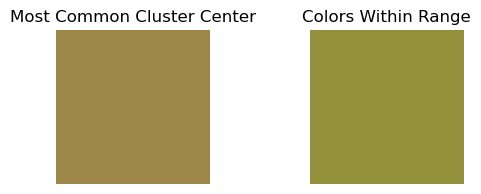

Most Dominant Color (in LAB): (array([135, 118, 154]), array([155, 138, 174]))



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 9.9ms preprocess, 57.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


2
Saved: temp_task_folder/img1/000002.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


3
Saved: temp_task_folder/img1/000003.jpg
4
Saved: temp_task_folder/img1/000004.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


5
Saved: temp_task_folder/img1/000005.jpg
6
Saved: temp_task_folder/img1/000006.jpg



0: 1088x1920 1 ball, 22 players, 57.7ms
Speed: 7.9ms preprocess, 57.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


7
Saved: temp_task_folder/img1/000007.jpg
8
Saved: temp_task_folder/img1/000008.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


9
Saved: temp_task_folder/img1/000009.jpg
10
Saved: temp_task_folder/img1/000010.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


11
Saved: temp_task_folder/img1/000011.jpg
12
Saved: temp_task_folder/img1/000012.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


13
Saved: temp_task_folder/img1/000013.jpg
14
Saved: temp_task_folder/img1/000014.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


15
Saved: temp_task_folder/img1/000015.jpg
16
Saved: temp_task_folder/img1/000016.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


17
Saved: temp_task_folder/img1/000017.jpg
18
Saved: temp_task_folder/img1/000018.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


19
Saved: temp_task_folder/img1/000019.jpg
20
Saved: temp_task_folder/img1/000020.jpg



0: 1088x1920 1 ball, 22 players, 57.8ms
Speed: 6.8ms preprocess, 57.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


21
Saved: temp_task_folder/img1/000021.jpg
22
Saved: temp_task_folder/img1/000022.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


23
Saved: temp_task_folder/img1/000023.jpg
24
Saved: temp_task_folder/img1/000024.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


25
Saved: temp_task_folder/img1/000025.jpg
26
Saved: temp_task_folder/img1/000026.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


27
Saved: temp_task_folder/img1/000027.jpg
28
Saved: temp_task_folder/img1/000028.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


29
Saved: temp_task_folder/img1/000029.jpg
30
Saved: temp_task_folder/img1/000030.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


31
Saved: temp_task_folder/img1/000031.jpg
32
Saved: temp_task_folder/img1/000032.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


33
Saved: temp_task_folder/img1/000033.jpg
34
Saved: temp_task_folder/img1/000034.jpg



0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


35
Saved: temp_task_folder/img1/000035.jpg
36
Saved: temp_task_folder/img1/000036.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


37
Saved: temp_task_folder/img1/000037.jpg
38
Saved: temp_task_folder/img1/000038.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


39
Saved: temp_task_folder/img1/000039.jpg
40
Saved: temp_task_folder/img1/000040.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


41
Saved: temp_task_folder/img1/000041.jpg
42
Saved: temp_task_folder/img1/000042.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 9.5ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


43
Saved: temp_task_folder/img1/000043.jpg
44
Saved: temp_task_folder/img1/000044.jpg



0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


45
Saved: temp_task_folder/img1/000045.jpg
46
Saved: temp_task_folder/img1/000046.jpg



0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


47
Saved: temp_task_folder/img1/000047.jpg
48
Saved: temp_task_folder/img1/000048.jpg



0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


49
Saved: temp_task_folder/img1/000049.jpg
50
Saved: temp_task_folder/img1/000050.jpg



0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


51
Saved: temp_task_folder/img1/000051.jpg
52
Saved: temp_task_folder/img1/000052.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


53
Saved: temp_task_folder/img1/000053.jpg
54
Saved: temp_task_folder/img1/000054.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


55
Saved: temp_task_folder/img1/000055.jpg
56
Saved: temp_task_folder/img1/000056.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


57
Saved: temp_task_folder/img1/000057.jpg
58
Saved: temp_task_folder/img1/000058.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


59
Saved: temp_task_folder/img1/000059.jpg
60
Saved: temp_task_folder/img1/000060.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


61
Saved: temp_task_folder/img1/000061.jpg
62
Saved: temp_task_folder/img1/000062.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


63
Saved: temp_task_folder/img1/000063.jpg
64
Saved: temp_task_folder/img1/000064.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


65
Saved: temp_task_folder/img1/000065.jpg
66
Saved: temp_task_folder/img1/000066.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


67
Saved: temp_task_folder/img1/000067.jpg
68
Saved: temp_task_folder/img1/000068.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


69
Saved: temp_task_folder/img1/000069.jpg
70
Saved: temp_task_folder/img1/000070.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 8.0ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


71
Saved: temp_task_folder/img1/000071.jpg
72
Saved: temp_task_folder/img1/000072.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


73
Saved: temp_task_folder/img1/000073.jpg
74
Saved: temp_task_folder/img1/000074.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


75
Saved: temp_task_folder/img1/000075.jpg
76
Saved: temp_task_folder/img1/000076.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


77
Saved: temp_task_folder/img1/000077.jpg
78
Saved: temp_task_folder/img1/000078.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


79
Saved: temp_task_folder/img1/000079.jpg
80
Saved: temp_task_folder/img1/000080.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


81
Saved: temp_task_folder/img1/000081.jpg
82
Saved: temp_task_folder/img1/000082.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


83
Saved: temp_task_folder/img1/000083.jpg
84
Saved: temp_task_folder/img1/000084.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


85
Saved: temp_task_folder/img1/000085.jpg
86
Saved: temp_task_folder/img1/000086.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


87
Saved: temp_task_folder/img1/000087.jpg
88
Saved: temp_task_folder/img1/000088.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.0ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


89
Saved: temp_task_folder/img1/000089.jpg
90
Saved: temp_task_folder/img1/000090.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


91
Saved: temp_task_folder/img1/000091.jpg
92
Saved: temp_task_folder/img1/000092.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


93
Saved: temp_task_folder/img1/000093.jpg
94
Saved: temp_task_folder/img1/000094.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


95
Saved: temp_task_folder/img1/000095.jpg
96
Saved: temp_task_folder/img1/000096.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


97
Saved: temp_task_folder/img1/000097.jpg
98
Saved: temp_task_folder/img1/000098.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


99
Saved: temp_task_folder/img1/000099.jpg
100
Saved: temp_task_folder/img1/000100.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


101
Saved: temp_task_folder/img1/000101.jpg
102
Saved: temp_task_folder/img1/000102.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


103
Saved: temp_task_folder/img1/000103.jpg
104
Saved: temp_task_folder/img1/000104.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


105
Saved: temp_task_folder/img1/000105.jpg
106
Saved: temp_task_folder/img1/000106.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


107
Saved: temp_task_folder/img1/000107.jpg
108
Saved: temp_task_folder/img1/000108.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


109
Saved: temp_task_folder/img1/000109.jpg
110
Saved: temp_task_folder/img1/000110.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


111
Saved: temp_task_folder/img1/000111.jpg
112
Saved: temp_task_folder/img1/000112.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


113
Saved: temp_task_folder/img1/000113.jpg
114
Saved: temp_task_folder/img1/000114.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.0ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


115
Saved: temp_task_folder/img1/000115.jpg
116
Saved: temp_task_folder/img1/000116.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.0ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


117
Saved: temp_task_folder/img1/000117.jpg
118
Saved: temp_task_folder/img1/000118.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.4ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


119
Saved: temp_task_folder/img1/000119.jpg
120
Saved: temp_task_folder/img1/000120.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


121
Saved: temp_task_folder/img1/000121.jpg
122
Saved: temp_task_folder/img1/000122.jpg



0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


123
Saved: temp_task_folder/img1/000123.jpg
124
Saved: temp_task_folder/img1/000124.jpg



0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 7.4ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.5ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


125
Saved: temp_task_folder/img1/000125.jpg
126
Saved: temp_task_folder/img1/000126.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.7ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


127
Saved: temp_task_folder/img1/000127.jpg
128
Saved: temp_task_folder/img1/000128.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


129
Saved: temp_task_folder/img1/000129.jpg
130
Saved: temp_task_folder/img1/000130.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


131
Saved: temp_task_folder/img1/000131.jpg
132
Saved: temp_task_folder/img1/000132.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1920)


133
Saved: temp_task_folder/img1/000133.jpg
134
Saved: temp_task_folder/img1/000134.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


135
Saved: temp_task_folder/img1/000135.jpg
136
Saved: temp_task_folder/img1/000136.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


137
Saved: temp_task_folder/img1/000137.jpg
138
Saved: temp_task_folder/img1/000138.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


139
Saved: temp_task_folder/img1/000139.jpg
140
Saved: temp_task_folder/img1/000140.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


141
Saved: temp_task_folder/img1/000141.jpg
142
Saved: temp_task_folder/img1/000142.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


143
Saved: temp_task_folder/img1/000143.jpg
144
Saved: temp_task_folder/img1/000144.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


145
Saved: temp_task_folder/img1/000145.jpg
146
Saved: temp_task_folder/img1/000146.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


147
Saved: temp_task_folder/img1/000147.jpg
148
Saved: temp_task_folder/img1/000148.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


149
Saved: temp_task_folder/img1/000149.jpg
150
Saved: temp_task_folder/img1/000150.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


151
Saved: temp_task_folder/img1/000151.jpg
152
Saved: temp_task_folder/img1/000152.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


153
Saved: temp_task_folder/img1/000153.jpg
154
Saved: temp_task_folder/img1/000154.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


155
Saved: temp_task_folder/img1/000155.jpg
156
Saved: temp_task_folder/img1/000156.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


157
Saved: temp_task_folder/img1/000157.jpg
158
Saved: temp_task_folder/img1/000158.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


159
Saved: temp_task_folder/img1/000159.jpg
160
Saved: temp_task_folder/img1/000160.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


161
Saved: temp_task_folder/img1/000161.jpg
162
Saved: temp_task_folder/img1/000162.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


163
Saved: temp_task_folder/img1/000163.jpg
164
Saved: temp_task_folder/img1/000164.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


165
Saved: temp_task_folder/img1/000165.jpg
166
Saved: temp_task_folder/img1/000166.jpg



0: 1088x1920 1 ball, 22 players, 57.1ms
Speed: 7.0ms preprocess, 57.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


167
Saved: temp_task_folder/img1/000167.jpg
168
Saved: temp_task_folder/img1/000168.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


169
Saved: temp_task_folder/img1/000169.jpg
170
Saved: temp_task_folder/img1/000170.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


171
Saved: temp_task_folder/img1/000171.jpg
172
Saved: temp_task_folder/img1/000172.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


173
Saved: temp_task_folder/img1/000173.jpg
174
Saved: temp_task_folder/img1/000174.jpg



0: 1088x1920 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


175
Saved: temp_task_folder/img1/000175.jpg
176
Saved: temp_task_folder/img1/000176.jpg



0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


177
Saved: temp_task_folder/img1/000177.jpg
178
Saved: temp_task_folder/img1/000178.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


179
Saved: temp_task_folder/img1/000179.jpg
180
Saved: temp_task_folder/img1/000180.jpg



0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


181
Saved: temp_task_folder/img1/000181.jpg
182
Saved: temp_task_folder/img1/000182.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


183
Saved: temp_task_folder/img1/000183.jpg
184
Saved: temp_task_folder/img1/000184.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.7ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


185
Saved: temp_task_folder/img1/000185.jpg
186
Saved: temp_task_folder/img1/000186.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


187
Saved: temp_task_folder/img1/000187.jpg
188
Saved: temp_task_folder/img1/000188.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


189
Saved: temp_task_folder/img1/000189.jpg
190
Saved: temp_task_folder/img1/000190.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


191
Saved: temp_task_folder/img1/000191.jpg
192
Saved: temp_task_folder/img1/000192.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.7ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


193
Saved: temp_task_folder/img1/000193.jpg
194
Saved: temp_task_folder/img1/000194.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


195
Saved: temp_task_folder/img1/000195.jpg
196
Saved: temp_task_folder/img1/000196.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.7ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


197
Saved: temp_task_folder/img1/000197.jpg
198
Saved: temp_task_folder/img1/000198.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


199
Saved: temp_task_folder/img1/000199.jpg
200
Saved: temp_task_folder/img1/000200.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


201
Saved: temp_task_folder/img1/000201.jpg
202
Saved: temp_task_folder/img1/000202.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


203
Saved: temp_task_folder/img1/000203.jpg
204
Saved: temp_task_folder/img1/000204.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


205
Saved: temp_task_folder/img1/000205.jpg
206
Saved: temp_task_folder/img1/000206.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


207
Saved: temp_task_folder/img1/000207.jpg
208
Saved: temp_task_folder/img1/000208.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


209
Saved: temp_task_folder/img1/000209.jpg
210
Saved: temp_task_folder/img1/000210.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


211
Saved: temp_task_folder/img1/000211.jpg
212
Saved: temp_task_folder/img1/000212.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


213
Saved: temp_task_folder/img1/000213.jpg
214
Saved: temp_task_folder/img1/000214.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


215
Saved: temp_task_folder/img1/000215.jpg
216
Saved: temp_task_folder/img1/000216.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


217
Saved: temp_task_folder/img1/000217.jpg
218
Saved: temp_task_folder/img1/000218.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


219
Saved: temp_task_folder/img1/000219.jpg
220
Saved: temp_task_folder/img1/000220.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


221
Saved: temp_task_folder/img1/000221.jpg
222
Saved: temp_task_folder/img1/000222.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


223
Saved: temp_task_folder/img1/000223.jpg
224
Saved: temp_task_folder/img1/000224.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


225
Saved: temp_task_folder/img1/000225.jpg
226
Saved: temp_task_folder/img1/000226.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


227
Saved: temp_task_folder/img1/000227.jpg
228
Saved: temp_task_folder/img1/000228.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.1ms
Speed: 6.9ms preprocess, 57.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


229
Saved: temp_task_folder/img1/000229.jpg
230
Saved: temp_task_folder/img1/000230.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


231
Saved: temp_task_folder/img1/000231.jpg
232
Saved: temp_task_folder/img1/000232.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


233
Saved: temp_task_folder/img1/000233.jpg
234
Saved: temp_task_folder/img1/000234.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


235
Saved: temp_task_folder/img1/000235.jpg
236
Saved: temp_task_folder/img1/000236.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


237
Saved: temp_task_folder/img1/000237.jpg
238
Saved: temp_task_folder/img1/000238.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


239
Saved: temp_task_folder/img1/000239.jpg
240
Saved: temp_task_folder/img1/000240.jpg



0: 1088x1920 1 ball, 22 players, 57.7ms
Speed: 6.9ms preprocess, 57.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


241
Saved: temp_task_folder/img1/000241.jpg
242
Saved: temp_task_folder/img1/000242.jpg



0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


243
Saved: temp_task_folder/img1/000243.jpg
244
Saved: temp_task_folder/img1/000244.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


245
Saved: temp_task_folder/img1/000245.jpg
246
Saved: temp_task_folder/img1/000246.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


247
Saved: temp_task_folder/img1/000247.jpg
248
Saved: temp_task_folder/img1/000248.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


249
Saved: temp_task_folder/img1/000249.jpg
250
Saved: temp_task_folder/img1/000250.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


251
Saved: temp_task_folder/img1/000251.jpg
252
Saved: temp_task_folder/img1/000252.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


253
Saved: temp_task_folder/img1/000253.jpg
254
Saved: temp_task_folder/img1/000254.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


255
Saved: temp_task_folder/img1/000255.jpg
256
Saved: temp_task_folder/img1/000256.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


257
Saved: temp_task_folder/img1/000257.jpg
258
Saved: temp_task_folder/img1/000258.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


259
Saved: temp_task_folder/img1/000259.jpg
260
Saved: temp_task_folder/img1/000260.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.0ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


261
Saved: temp_task_folder/img1/000261.jpg
262
Saved: temp_task_folder/img1/000262.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


263
Saved: temp_task_folder/img1/000263.jpg
264
Saved: temp_task_folder/img1/000264.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.7ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


265
Saved: temp_task_folder/img1/000265.jpg
266
Saved: temp_task_folder/img1/000266.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


267
Saved: temp_task_folder/img1/000267.jpg
268
Saved: temp_task_folder/img1/000268.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


269
Saved: temp_task_folder/img1/000269.jpg
270
Saved: temp_task_folder/img1/000270.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


271
Saved: temp_task_folder/img1/000271.jpg
272
Saved: temp_task_folder/img1/000272.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


273
Saved: temp_task_folder/img1/000273.jpg
274
Saved: temp_task_folder/img1/000274.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


275
Saved: temp_task_folder/img1/000275.jpg
276
Saved: temp_task_folder/img1/000276.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


277
Saved: temp_task_folder/img1/000277.jpg
278
Saved: temp_task_folder/img1/000278.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


279
Saved: temp_task_folder/img1/000279.jpg
280
Saved: temp_task_folder/img1/000280.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


281
Saved: temp_task_folder/img1/000281.jpg
282
Saved: temp_task_folder/img1/000282.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


283
Saved: temp_task_folder/img1/000283.jpg
284
Saved: temp_task_folder/img1/000284.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


285
Saved: temp_task_folder/img1/000285.jpg
286
Saved: temp_task_folder/img1/000286.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


287
Saved: temp_task_folder/img1/000287.jpg
288
Saved: temp_task_folder/img1/000288.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


289
Saved: temp_task_folder/img1/000289.jpg
290
Saved: temp_task_folder/img1/000290.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


291
Saved: temp_task_folder/img1/000291.jpg
292
Saved: temp_task_folder/img1/000292.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


293
Saved: temp_task_folder/img1/000293.jpg
294
Saved: temp_task_folder/img1/000294.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


295
Saved: temp_task_folder/img1/000295.jpg
296
Saved: temp_task_folder/img1/000296.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


297
Saved: temp_task_folder/img1/000297.jpg
298
Saved: temp_task_folder/img1/000298.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


299
Saved: temp_task_folder/img1/000299.jpg
300
Saved: temp_task_folder/img1/000300.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


301
Saved: temp_task_folder/img1/000301.jpg
302
Saved: temp_task_folder/img1/000302.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 8.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


303
Saved: temp_task_folder/img1/000303.jpg
304
Saved: temp_task_folder/img1/000304.jpg



0: 1088x1920 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


305
Saved: temp_task_folder/img1/000305.jpg



0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


306
Saved: temp_task_folder/img1/000306.jpg
307
Saved: temp_task_folder/img1/000307.jpg



0: 1088x1920 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


308
Saved: temp_task_folder/img1/000308.jpg
309
Saved: temp_task_folder/img1/000309.jpg



0: 1088x1920 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


310
Saved: temp_task_folder/img1/000310.jpg
311
Saved: temp_task_folder/img1/000311.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


312
Saved: temp_task_folder/img1/000312.jpg
313
Saved: temp_task_folder/img1/000313.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


314
Saved: temp_task_folder/img1/000314.jpg
315
Saved: temp_task_folder/img1/000315.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


316
Saved: temp_task_folder/img1/000316.jpg
317
Saved: temp_task_folder/img1/000317.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


318
Saved: temp_task_folder/img1/000318.jpg
319
Saved: temp_task_folder/img1/000319.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


320
Saved: temp_task_folder/img1/000320.jpg
321
Saved: temp_task_folder/img1/000321.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


322
Saved: temp_task_folder/img1/000322.jpg
323
Saved: temp_task_folder/img1/000323.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


324
Saved: temp_task_folder/img1/000324.jpg
325
Saved: temp_task_folder/img1/000325.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


326
Saved: temp_task_folder/img1/000326.jpg
327
Saved: temp_task_folder/img1/000327.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


328
Saved: temp_task_folder/img1/000328.jpg
329
Saved: temp_task_folder/img1/000329.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


330
Saved: temp_task_folder/img1/000330.jpg
331
Saved: temp_task_folder/img1/000331.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


332
Saved: temp_task_folder/img1/000332.jpg
333
Saved: temp_task_folder/img1/000333.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


334
Saved: temp_task_folder/img1/000334.jpg
335
Saved: temp_task_folder/img1/000335.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


336
Saved: temp_task_folder/img1/000336.jpg
337
Saved: temp_task_folder/img1/000337.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


338
Saved: temp_task_folder/img1/000338.jpg
339
Saved: temp_task_folder/img1/000339.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


340
Saved: temp_task_folder/img1/000340.jpg
341
Saved: temp_task_folder/img1/000341.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


342
Saved: temp_task_folder/img1/000342.jpg
343
Saved: temp_task_folder/img1/000343.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


344
Saved: temp_task_folder/img1/000344.jpg
345
Saved: temp_task_folder/img1/000345.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


346
Saved: temp_task_folder/img1/000346.jpg
347
Saved: temp_task_folder/img1/000347.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.1ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


348
Saved: temp_task_folder/img1/000348.jpg
349
Saved: temp_task_folder/img1/000349.jpg



0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


350
Saved: temp_task_folder/img1/000350.jpg
351
Saved: temp_task_folder/img1/000351.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


352
Saved: temp_task_folder/img1/000352.jpg
353
Saved: temp_task_folder/img1/000353.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


354
Saved: temp_task_folder/img1/000354.jpg
355
Saved: temp_task_folder/img1/000355.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


356
Saved: temp_task_folder/img1/000356.jpg
357
Saved: temp_task_folder/img1/000357.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


358
Saved: temp_task_folder/img1/000358.jpg
359
Saved: temp_task_folder/img1/000359.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


360
Saved: temp_task_folder/img1/000360.jpg
361
Saved: temp_task_folder/img1/000361.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


362
Saved: temp_task_folder/img1/000362.jpg
363
Saved: temp_task_folder/img1/000363.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


364
Saved: temp_task_folder/img1/000364.jpg
365
Saved: temp_task_folder/img1/000365.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


366
Saved: temp_task_folder/img1/000366.jpg
367
Saved: temp_task_folder/img1/000367.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


368
Saved: temp_task_folder/img1/000368.jpg
369
Saved: temp_task_folder/img1/000369.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


370
Saved: temp_task_folder/img1/000370.jpg
371
Saved: temp_task_folder/img1/000371.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.0ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.1ms
Speed: 6.9ms preprocess, 57.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


372
Saved: temp_task_folder/img1/000372.jpg
373
Saved: temp_task_folder/img1/000373.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


374
Saved: temp_task_folder/img1/000374.jpg
375
Saved: temp_task_folder/img1/000375.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


376
Saved: temp_task_folder/img1/000376.jpg
377
Saved: temp_task_folder/img1/000377.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


378
Saved: temp_task_folder/img1/000378.jpg
379
Saved: temp_task_folder/img1/000379.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


380
Saved: temp_task_folder/img1/000380.jpg
381
Saved: temp_task_folder/img1/000381.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


382
Saved: temp_task_folder/img1/000382.jpg
383
Saved: temp_task_folder/img1/000383.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


384
Saved: temp_task_folder/img1/000384.jpg
385
Saved: temp_task_folder/img1/000385.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.0ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


386
Saved: temp_task_folder/img1/000386.jpg
387
Saved: temp_task_folder/img1/000387.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


388
Saved: temp_task_folder/img1/000388.jpg
389
Saved: temp_task_folder/img1/000389.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


390
Saved: temp_task_folder/img1/000390.jpg
391
Saved: temp_task_folder/img1/000391.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


392
Saved: temp_task_folder/img1/000392.jpg
393
Saved: temp_task_folder/img1/000393.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


394
Saved: temp_task_folder/img1/000394.jpg
395
Saved: temp_task_folder/img1/000395.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


396
Saved: temp_task_folder/img1/000396.jpg
397
Saved: temp_task_folder/img1/000397.jpg



0: 1088x1920 1 ball, 22 players, 57.1ms
Speed: 6.9ms preprocess, 57.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


398
Saved: temp_task_folder/img1/000398.jpg
399
Saved: temp_task_folder/img1/000399.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


400
Saved: temp_task_folder/img1/000400.jpg
401
Saved: temp_task_folder/img1/000401.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


402
Saved: temp_task_folder/img1/000402.jpg
403
Saved: temp_task_folder/img1/000403.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


404
Saved: temp_task_folder/img1/000404.jpg
405
Saved: temp_task_folder/img1/000405.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


406
Saved: temp_task_folder/img1/000406.jpg
407
Saved: temp_task_folder/img1/000407.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


408
Saved: temp_task_folder/img1/000408.jpg
409
Saved: temp_task_folder/img1/000409.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


410
Saved: temp_task_folder/img1/000410.jpg
411
Saved: temp_task_folder/img1/000411.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


412
Saved: temp_task_folder/img1/000412.jpg
413
Saved: temp_task_folder/img1/000413.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


414
Saved: temp_task_folder/img1/000414.jpg
415
Saved: temp_task_folder/img1/000415.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.7ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


416
Saved: temp_task_folder/img1/000416.jpg
417
Saved: temp_task_folder/img1/000417.jpg



0: 1088x1920 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


418
Saved: temp_task_folder/img1/000418.jpg
419
Saved: temp_task_folder/img1/000419.jpg



0: 1088x1920 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


420
Saved: temp_task_folder/img1/000420.jpg
421
Saved: temp_task_folder/img1/000421.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


422
Saved: temp_task_folder/img1/000422.jpg



0: 1088x1920 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


423
Saved: temp_task_folder/img1/000423.jpg
424
Saved: temp_task_folder/img1/000424.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


425
Saved: temp_task_folder/img1/000425.jpg
426
Saved: temp_task_folder/img1/000426.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


427
Saved: temp_task_folder/img1/000427.jpg
428
Saved: temp_task_folder/img1/000428.jpg



0: 1088x1920 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


429
Saved: temp_task_folder/img1/000429.jpg
430
Saved: temp_task_folder/img1/000430.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


431
Saved: temp_task_folder/img1/000431.jpg
432
Saved: temp_task_folder/img1/000432.jpg



0: 1088x1920 2 balls, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 7.0ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


433
Saved: temp_task_folder/img1/000433.jpg
434
Saved: temp_task_folder/img1/000434.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


435
Saved: temp_task_folder/img1/000435.jpg
436
Saved: temp_task_folder/img1/000436.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


437
Saved: temp_task_folder/img1/000437.jpg
438
Saved: temp_task_folder/img1/000438.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


439
Saved: temp_task_folder/img1/000439.jpg
440
Saved: temp_task_folder/img1/000440.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


441
Saved: temp_task_folder/img1/000441.jpg
442
Saved: temp_task_folder/img1/000442.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


443
Saved: temp_task_folder/img1/000443.jpg
444
Saved: temp_task_folder/img1/000444.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 7.0ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


445
Saved: temp_task_folder/img1/000445.jpg
446
Saved: temp_task_folder/img1/000446.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


447
Saved: temp_task_folder/img1/000447.jpg
448
Saved: temp_task_folder/img1/000448.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


449
Saved: temp_task_folder/img1/000449.jpg
450
Saved: temp_task_folder/img1/000450.jpg



0: 1088x1920 1 ball, 23 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


451
Saved: temp_task_folder/img1/000451.jpg
452
Saved: temp_task_folder/img1/000452.jpg



0: 1088x1920 1 ball, 23 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


453
Saved: temp_task_folder/img1/000453.jpg
454
Saved: temp_task_folder/img1/000454.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


455
Saved: temp_task_folder/img1/000455.jpg
456
Saved: temp_task_folder/img1/000456.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


457
Saved: temp_task_folder/img1/000457.jpg
458
Saved: temp_task_folder/img1/000458.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


459
Saved: temp_task_folder/img1/000459.jpg
460
Saved: temp_task_folder/img1/000460.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


461
Saved: temp_task_folder/img1/000461.jpg
462
Saved: temp_task_folder/img1/000462.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


463
Saved: temp_task_folder/img1/000463.jpg
464
Saved: temp_task_folder/img1/000464.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


465
Saved: temp_task_folder/img1/000465.jpg
466
Saved: temp_task_folder/img1/000466.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


467
Saved: temp_task_folder/img1/000467.jpg
468
Saved: temp_task_folder/img1/000468.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.0ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


469
Saved: temp_task_folder/img1/000469.jpg
470
Saved: temp_task_folder/img1/000470.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


471
Saved: temp_task_folder/img1/000471.jpg
472
Saved: temp_task_folder/img1/000472.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


473
Saved: temp_task_folder/img1/000473.jpg
474
Saved: temp_task_folder/img1/000474.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


475
Saved: temp_task_folder/img1/000475.jpg
476
Saved: temp_task_folder/img1/000476.jpg



0: 1088x1920 1 ball, 23 players, 57.0ms
Speed: 6.9ms preprocess, 57.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


477
Saved: temp_task_folder/img1/000477.jpg
478
Saved: temp_task_folder/img1/000478.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


479
Saved: temp_task_folder/img1/000479.jpg
480
Saved: temp_task_folder/img1/000480.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


481
Saved: temp_task_folder/img1/000481.jpg
482
Saved: temp_task_folder/img1/000482.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


483
Saved: temp_task_folder/img1/000483.jpg
484
Saved: temp_task_folder/img1/000484.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


485
Saved: temp_task_folder/img1/000485.jpg
486
Saved: temp_task_folder/img1/000486.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


487
Saved: temp_task_folder/img1/000487.jpg
488
Saved: temp_task_folder/img1/000488.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


489
Saved: temp_task_folder/img1/000489.jpg
490
Saved: temp_task_folder/img1/000490.jpg



0: 1088x1920 2 balls, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


491
Saved: temp_task_folder/img1/000491.jpg
492
Saved: temp_task_folder/img1/000492.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


493
Saved: temp_task_folder/img1/000493.jpg
494
Saved: temp_task_folder/img1/000494.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


495
Saved: temp_task_folder/img1/000495.jpg
496
Saved: temp_task_folder/img1/000496.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


497
Saved: temp_task_folder/img1/000497.jpg
498
Saved: temp_task_folder/img1/000498.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


499
Saved: temp_task_folder/img1/000499.jpg
500
Saved: temp_task_folder/img1/000500.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


501
Saved: temp_task_folder/img1/000501.jpg
502
Saved: temp_task_folder/img1/000502.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


503
Saved: temp_task_folder/img1/000503.jpg
504
Saved: temp_task_folder/img1/000504.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


505
Saved: temp_task_folder/img1/000505.jpg
506
Saved: temp_task_folder/img1/000506.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


507
Saved: temp_task_folder/img1/000507.jpg
508
Saved: temp_task_folder/img1/000508.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


509
Saved: temp_task_folder/img1/000509.jpg
510
Saved: temp_task_folder/img1/000510.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


511
Saved: temp_task_folder/img1/000511.jpg
512
Saved: temp_task_folder/img1/000512.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


513
Saved: temp_task_folder/img1/000513.jpg
514
Saved: temp_task_folder/img1/000514.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


515
Saved: temp_task_folder/img1/000515.jpg
516
Saved: temp_task_folder/img1/000516.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


517
Saved: temp_task_folder/img1/000517.jpg
518
Saved: temp_task_folder/img1/000518.jpg



0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


519
Saved: temp_task_folder/img1/000519.jpg
520
Saved: temp_task_folder/img1/000520.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.7ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


521
Saved: temp_task_folder/img1/000521.jpg
522
Saved: temp_task_folder/img1/000522.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


523
Saved: temp_task_folder/img1/000523.jpg
524
Saved: temp_task_folder/img1/000524.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


525
Saved: temp_task_folder/img1/000525.jpg
526
Saved: temp_task_folder/img1/000526.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


527
Saved: temp_task_folder/img1/000527.jpg
528
Saved: temp_task_folder/img1/000528.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


529
Saved: temp_task_folder/img1/000529.jpg
530
Saved: temp_task_folder/img1/000530.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


531
Saved: temp_task_folder/img1/000531.jpg
532
Saved: temp_task_folder/img1/000532.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


533
Saved: temp_task_folder/img1/000533.jpg
534
Saved: temp_task_folder/img1/000534.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


535
Saved: temp_task_folder/img1/000535.jpg
536
Saved: temp_task_folder/img1/000536.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


537
Saved: temp_task_folder/img1/000537.jpg
538
Saved: temp_task_folder/img1/000538.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


539
Saved: temp_task_folder/img1/000539.jpg
540
Saved: temp_task_folder/img1/000540.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


541
Saved: temp_task_folder/img1/000541.jpg
542



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000542.jpg
543
Saved: temp_task_folder/img1/000543.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 7.0ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 7.0ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


544
Saved: temp_task_folder/img1/000544.jpg
545
Saved: temp_task_folder/img1/000545.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


546
Saved: temp_task_folder/img1/000546.jpg
547
Saved: temp_task_folder/img1/000547.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


548
Saved: temp_task_folder/img1/000548.jpg
549
Saved: temp_task_folder/img1/000549.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 7.1ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


550
Saved: temp_task_folder/img1/000550.jpg
551
Saved: temp_task_folder/img1/000551.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.7ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


552
Saved: temp_task_folder/img1/000552.jpg
553
Saved: temp_task_folder/img1/000553.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


554
Saved: temp_task_folder/img1/000554.jpg
555
Saved: temp_task_folder/img1/000555.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


556
Saved: temp_task_folder/img1/000556.jpg
557
Saved: temp_task_folder/img1/000557.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


558
Saved: temp_task_folder/img1/000558.jpg
559
Saved: temp_task_folder/img1/000559.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


560
Saved: temp_task_folder/img1/000560.jpg
561
Saved: temp_task_folder/img1/000561.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


562
Saved: temp_task_folder/img1/000562.jpg
563
Saved: temp_task_folder/img1/000563.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


564
Saved: temp_task_folder/img1/000564.jpg
565
Saved: temp_task_folder/img1/000565.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


566
Saved: temp_task_folder/img1/000566.jpg
567
Saved: temp_task_folder/img1/000567.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1920)


568
Saved: temp_task_folder/img1/000568.jpg
569
Saved: temp_task_folder/img1/000569.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


570
Saved: temp_task_folder/img1/000570.jpg
571
Saved: temp_task_folder/img1/000571.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


572
Saved: temp_task_folder/img1/000572.jpg
573
Saved: temp_task_folder/img1/000573.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 7.0ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


574
Saved: temp_task_folder/img1/000574.jpg
575
Saved: temp_task_folder/img1/000575.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


576
Saved: temp_task_folder/img1/000576.jpg
577
Saved: temp_task_folder/img1/000577.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.7ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


578
Saved: temp_task_folder/img1/000578.jpg
579
Saved: temp_task_folder/img1/000579.jpg



0: 1088x1920 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


580
Saved: temp_task_folder/img1/000580.jpg
581
Saved: temp_task_folder/img1/000581.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


582
Saved: temp_task_folder/img1/000582.jpg
583
Saved: temp_task_folder/img1/000583.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


584
Saved: temp_task_folder/img1/000584.jpg
585
Saved: temp_task_folder/img1/000585.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


586
Saved: temp_task_folder/img1/000586.jpg
587
Saved: temp_task_folder/img1/000587.jpg



0: 1088x1920 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


588
Saved: temp_task_folder/img1/000588.jpg
589
Saved: temp_task_folder/img1/000589.jpg



0: 1088x1920 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


590
Saved: temp_task_folder/img1/000590.jpg
591



0: 1088x1920 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000591.jpg
592
Saved: temp_task_folder/img1/000592.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 3 balls, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


593
Saved: temp_task_folder/img1/000593.jpg
594
Saved: temp_task_folder/img1/000594.jpg



0: 1088x1920 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


595
Saved: temp_task_folder/img1/000595.jpg
596
Saved: temp_task_folder/img1/000596.jpg



0: 1088x1920 23 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.3ms
Speed: 6.7ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


597
Saved: temp_task_folder/img1/000597.jpg
598
Saved: temp_task_folder/img1/000598.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


599
Saved: temp_task_folder/img1/000599.jpg
600
Saved: temp_task_folder/img1/000600.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.7ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


601
Saved: temp_task_folder/img1/000601.jpg
602
Saved: temp_task_folder/img1/000602.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


603
Saved: temp_task_folder/img1/000603.jpg
604
Saved: temp_task_folder/img1/000604.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.7ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


605
Saved: temp_task_folder/img1/000605.jpg
606



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000606.jpg
607
Saved: temp_task_folder/img1/000607.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


608
Saved: temp_task_folder/img1/000608.jpg
609



0: 1088x1920 1 ball, 23 players, 65.1ms
Speed: 6.8ms preprocess, 65.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000609.jpg
610



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000610.jpg
611
Saved: temp_task_folder/img1/000611.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


612
Saved: temp_task_folder/img1/000612.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


613
Saved: temp_task_folder/img1/000613.jpg
614
Saved: temp_task_folder/img1/000614.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


615
Saved: temp_task_folder/img1/000615.jpg
616
Saved: temp_task_folder/img1/000616.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


617
Saved: temp_task_folder/img1/000617.jpg
618



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000618.jpg
619
Saved: temp_task_folder/img1/000619.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


620
Saved: temp_task_folder/img1/000620.jpg
621
Saved: temp_task_folder/img1/000621.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


622
Saved: temp_task_folder/img1/000622.jpg
623
Saved: temp_task_folder/img1/000623.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


624
Saved: temp_task_folder/img1/000624.jpg
625
Saved: temp_task_folder/img1/000625.jpg



0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


626
Saved: temp_task_folder/img1/000626.jpg
627
Saved: temp_task_folder/img1/000627.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


628
Saved: temp_task_folder/img1/000628.jpg
629
Saved: temp_task_folder/img1/000629.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


630
Saved: temp_task_folder/img1/000630.jpg
631
Saved: temp_task_folder/img1/000631.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


632
Saved: temp_task_folder/img1/000632.jpg
633
Saved: temp_task_folder/img1/000633.jpg



0: 1088x1920 23 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


634
Saved: temp_task_folder/img1/000634.jpg
635
Saved: temp_task_folder/img1/000635.jpg



0: 1088x1920 1 ball, 24 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


636
Saved: temp_task_folder/img1/000636.jpg
637
Saved: temp_task_folder/img1/000637.jpg



0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


638
Saved: temp_task_folder/img1/000638.jpg
639
Saved: temp_task_folder/img1/000639.jpg



0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


640
Saved: temp_task_folder/img1/000640.jpg
641
Saved: temp_task_folder/img1/000641.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


642
Saved: temp_task_folder/img1/000642.jpg
643
Saved: temp_task_folder/img1/000643.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


644
Saved: temp_task_folder/img1/000644.jpg
645
Saved: temp_task_folder/img1/000645.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


646
Saved: temp_task_folder/img1/000646.jpg
647
Saved: temp_task_folder/img1/000647.jpg



0: 1088x1920 1 ball, 24 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


648
Saved: temp_task_folder/img1/000648.jpg
649
Saved: temp_task_folder/img1/000649.jpg



0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


650
Saved: temp_task_folder/img1/000650.jpg
651
Saved: temp_task_folder/img1/000651.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


652
Saved: temp_task_folder/img1/000652.jpg
653
Saved: temp_task_folder/img1/000653.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


654
Saved: temp_task_folder/img1/000654.jpg
655
Saved: temp_task_folder/img1/000655.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


656
Saved: temp_task_folder/img1/000656.jpg
657
Saved: temp_task_folder/img1/000657.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.1ms
Speed: 6.8ms preprocess, 57.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


658
Saved: temp_task_folder/img1/000658.jpg
659
Saved: temp_task_folder/img1/000659.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


660
Saved: temp_task_folder/img1/000660.jpg
661
Saved: temp_task_folder/img1/000661.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


662
Saved: temp_task_folder/img1/000662.jpg
663
Saved: temp_task_folder/img1/000663.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


664
Saved: temp_task_folder/img1/000664.jpg
665
Saved: temp_task_folder/img1/000665.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


666
Saved: temp_task_folder/img1/000666.jpg
667
Saved: temp_task_folder/img1/000667.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


668
Saved: temp_task_folder/img1/000668.jpg
669
Saved: temp_task_folder/img1/000669.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


670
Saved: temp_task_folder/img1/000670.jpg
671
Saved: temp_task_folder/img1/000671.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


672
Saved: temp_task_folder/img1/000672.jpg
673
Saved: temp_task_folder/img1/000673.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


674
Saved: temp_task_folder/img1/000674.jpg
675
Saved: temp_task_folder/img1/000675.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


676
Saved: temp_task_folder/img1/000676.jpg
677
Saved: temp_task_folder/img1/000677.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


678
Saved: temp_task_folder/img1/000678.jpg
679
Saved: temp_task_folder/img1/000679.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


680
Saved: temp_task_folder/img1/000680.jpg
681
Saved: temp_task_folder/img1/000681.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


682
Saved: temp_task_folder/img1/000682.jpg
683
Saved: temp_task_folder/img1/000683.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


684
Saved: temp_task_folder/img1/000684.jpg
685
Saved: temp_task_folder/img1/000685.jpg



0: 1088x1920 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


686
Saved: temp_task_folder/img1/000686.jpg
687
Saved: temp_task_folder/img1/000687.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.7ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


688
Saved: temp_task_folder/img1/000688.jpg
689
Saved: temp_task_folder/img1/000689.jpg



0: 1088x1920 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


690
Saved: temp_task_folder/img1/000690.jpg
691
Saved: temp_task_folder/img1/000691.jpg



0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


692
Saved: temp_task_folder/img1/000692.jpg
693
Saved: temp_task_folder/img1/000693.jpg



0: 1088x1920 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


694
Saved: temp_task_folder/img1/000694.jpg
695
Saved: temp_task_folder/img1/000695.jpg



0: 1088x1920 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


696
Saved: temp_task_folder/img1/000696.jpg
697
Saved: temp_task_folder/img1/000697.jpg



0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


698
Saved: temp_task_folder/img1/000698.jpg
699
Saved: temp_task_folder/img1/000699.jpg



0: 1088x1920 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


700
Saved: temp_task_folder/img1/000700.jpg
701
Saved: temp_task_folder/img1/000701.jpg



0: 1088x1920 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


702
Saved: temp_task_folder/img1/000702.jpg
703
Saved: temp_task_folder/img1/000703.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


704
Saved: temp_task_folder/img1/000704.jpg
705
Saved: temp_task_folder/img1/000705.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.1ms
Speed: 6.8ms preprocess, 57.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


706
Saved: temp_task_folder/img1/000706.jpg
707
Saved: temp_task_folder/img1/000707.jpg



0: 1088x1920 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


708
Saved: temp_task_folder/img1/000708.jpg
709
Saved: temp_task_folder/img1/000709.jpg



0: 1088x1920 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


710
Saved: temp_task_folder/img1/000710.jpg
711
Saved: temp_task_folder/img1/000711.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 7.0ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


712
Saved: temp_task_folder/img1/000712.jpg
713
Saved: temp_task_folder/img1/000713.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


714
Saved: temp_task_folder/img1/000714.jpg
715
Saved: temp_task_folder/img1/000715.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


716
Saved: temp_task_folder/img1/000716.jpg
717
Saved: temp_task_folder/img1/000717.jpg



0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


718
Saved: temp_task_folder/img1/000718.jpg
719
Saved: temp_task_folder/img1/000719.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


720
Saved: temp_task_folder/img1/000720.jpg
721
Saved: temp_task_folder/img1/000721.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


722
Saved: temp_task_folder/img1/000722.jpg
723
Saved: temp_task_folder/img1/000723.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


724
Saved: temp_task_folder/img1/000724.jpg
725
Saved: temp_task_folder/img1/000725.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


726
Saved: temp_task_folder/img1/000726.jpg
727



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000727.jpg
728
Saved: temp_task_folder/img1/000728.jpg



0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 25 players, 57.4ms
Speed: 6.7ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


729
Saved: temp_task_folder/img1/000729.jpg



0: 1088x1920 1 ball, 25 players, 57.4ms
Speed: 6.7ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


730
Saved: temp_task_folder/img1/000730.jpg
731



0: 1088x1920 1 ball, 24 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000731.jpg
732
Saved: temp_task_folder/img1/000732.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


733
Saved: temp_task_folder/img1/000733.jpg
734
Saved: temp_task_folder/img1/000734.jpg



0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


735
Saved: temp_task_folder/img1/000735.jpg
736
Saved: temp_task_folder/img1/000736.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 7.1ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


737
Saved: temp_task_folder/img1/000737.jpg
738
Saved: temp_task_folder/img1/000738.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


739
Saved: temp_task_folder/img1/000739.jpg
740
Saved: temp_task_folder/img1/000740.jpg



0: 1088x1920 2 balls, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


741
Saved: temp_task_folder/img1/000741.jpg
742
Saved: temp_task_folder/img1/000742.jpg



0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


743
Saved: temp_task_folder/img1/000743.jpg
744
Saved: temp_task_folder/img1/000744.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


745
Saved: temp_task_folder/img1/000745.jpg
746
Saved: temp_task_folder/img1/000746.jpg



0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


747
Saved: temp_task_folder/img1/000747.jpg
748
Saved: temp_task_folder/img1/000748.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


749
Saved: temp_task_folder/img1/000749.jpg
750
Saved: temp_task_folder/img1/000750.jpg



0: 1088x1920 24 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


751
Saved: temp_task_folder/img1/000751.jpg
752
Saved: temp_task_folder/img1/000752.jpg



0: 1088x1920 24 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


753
Saved: temp_task_folder/img1/000753.jpg
754
Saved: temp_task_folder/img1/000754.jpg



0: 1088x1920 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


755
Saved: temp_task_folder/img1/000755.jpg
756
Saved: temp_task_folder/img1/000756.jpg



0: 1088x1920 24 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


757
Saved: temp_task_folder/img1/000757.jpg
758
Saved: temp_task_folder/img1/000758.jpg



0: 1088x1920 1 ball, 25 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 25 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


759
Saved: temp_task_folder/img1/000759.jpg
760
Saved: temp_task_folder/img1/000760.jpg



0: 1088x1920 1 ball, 25 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 24 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


761
Saved: temp_task_folder/img1/000761.jpg
762
Saved: temp_task_folder/img1/000762.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


763
Saved: temp_task_folder/img1/000763.jpg
764
Saved: temp_task_folder/img1/000764.jpg



0: 1088x1920 2 balls, 24 players, 57.2ms
Speed: 7.2ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 24 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


765
Saved: temp_task_folder/img1/000765.jpg
766
Saved: temp_task_folder/img1/000766.jpg



0: 1088x1920 2 balls, 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


767
Saved: temp_task_folder/img1/000767.jpg
768
Saved: temp_task_folder/img1/000768.jpg



0: 1088x1920 3 balls, 24 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 24 players, 57.2ms
Speed: 7.3ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


769
Saved: temp_task_folder/img1/000769.jpg
770



0: 1088x1920 2 balls, 24 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000770.jpg
771
Saved: temp_task_folder/img1/000771.jpg



0: 1088x1920 3 balls, 25 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 25 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


772
Saved: temp_task_folder/img1/000772.jpg
773
Saved: temp_task_folder/img1/000773.jpg



0: 1088x1920 1 ball, 25 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 25 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


774
Saved: temp_task_folder/img1/000774.jpg
775
Saved: temp_task_folder/img1/000775.jpg



0: 1088x1920 1 ball, 25 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 27 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


776
Saved: temp_task_folder/img1/000776.jpg
777
Saved: temp_task_folder/img1/000777.jpg



0: 1088x1920 26 players, 57.2ms
Speed: 7.2ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 26 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


778
Saved: temp_task_folder/img1/000778.jpg
779
Saved: temp_task_folder/img1/000779.jpg



0: 1088x1920 25 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 26 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


780
Saved: temp_task_folder/img1/000780.jpg
781
Saved: temp_task_folder/img1/000781.jpg



0: 1088x1920 24 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 25 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


782
Saved: temp_task_folder/img1/000782.jpg
783



0: 1088x1920 25 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000783.jpg
784
Saved: temp_task_folder/img1/000784.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


785
Saved: temp_task_folder/img1/000785.jpg
786
Saved: temp_task_folder/img1/000786.jpg



0: 1088x1920 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


787
Saved: temp_task_folder/img1/000787.jpg
788
Saved: temp_task_folder/img1/000788.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


789
Saved: temp_task_folder/img1/000789.jpg
790
Saved: temp_task_folder/img1/000790.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.5ms
Speed: 6.7ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


791
Saved: temp_task_folder/img1/000791.jpg
792
Saved: temp_task_folder/img1/000792.jpg



0: 1088x1920 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


793
Saved: temp_task_folder/img1/000793.jpg
794
Saved: temp_task_folder/img1/000794.jpg



0: 1088x1920 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


795
Saved: temp_task_folder/img1/000795.jpg
796
Saved: temp_task_folder/img1/000796.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.3ms
Speed: 7.3ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


797
Saved: temp_task_folder/img1/000797.jpg
798
Saved: temp_task_folder/img1/000798.jpg



0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


799
Saved: temp_task_folder/img1/000799.jpg
800
Saved: temp_task_folder/img1/000800.jpg



0: 1088x1920 1 ball, 21 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


801
Saved: temp_task_folder/img1/000801.jpg
802
Saved: temp_task_folder/img1/000802.jpg



0: 1088x1920 1 ball, 21 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


803
Saved: temp_task_folder/img1/000803.jpg
804
Saved: temp_task_folder/img1/000804.jpg



0: 1088x1920 1 ball, 21 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


805
Saved: temp_task_folder/img1/000805.jpg
806
Saved: temp_task_folder/img1/000806.jpg



0: 1088x1920 21 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


807
Saved: temp_task_folder/img1/000807.jpg
808
Saved: temp_task_folder/img1/000808.jpg



0: 1088x1920 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


809
Saved: temp_task_folder/img1/000809.jpg
810
Saved: temp_task_folder/img1/000810.jpg



0: 1088x1920 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


811
Saved: temp_task_folder/img1/000811.jpg
812
Saved: temp_task_folder/img1/000812.jpg



0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


813
Saved: temp_task_folder/img1/000813.jpg
814
Saved: temp_task_folder/img1/000814.jpg



0: 1088x1920 1 ball, 21 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


815
Saved: temp_task_folder/img1/000815.jpg
816
Saved: temp_task_folder/img1/000816.jpg



0: 1088x1920 2 balls, 21 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


817
Saved: temp_task_folder/img1/000817.jpg
818
Saved: temp_task_folder/img1/000818.jpg



0: 1088x1920 1 ball, 21 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


819
Saved: temp_task_folder/img1/000819.jpg
820
Saved: temp_task_folder/img1/000820.jpg



0: 1088x1920 1 ball, 21 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


821
Saved: temp_task_folder/img1/000821.jpg
822
Saved: temp_task_folder/img1/000822.jpg



0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


823
Saved: temp_task_folder/img1/000823.jpg
824
Saved: temp_task_folder/img1/000824.jpg



0: 1088x1920 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


825
Saved: temp_task_folder/img1/000825.jpg
826
Saved: temp_task_folder/img1/000826.jpg



0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


827
Saved: temp_task_folder/img1/000827.jpg
828
Saved: temp_task_folder/img1/000828.jpg



0: 1088x1920 1 ball, 21 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


829
Saved: temp_task_folder/img1/000829.jpg
830
Saved: temp_task_folder/img1/000830.jpg



0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


831
Saved: temp_task_folder/img1/000831.jpg
832
Saved: temp_task_folder/img1/000832.jpg



0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


833
Saved: temp_task_folder/img1/000833.jpg
834
Saved: temp_task_folder/img1/000834.jpg



0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


835
Saved: temp_task_folder/img1/000835.jpg
836



0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000836.jpg
837
Saved: temp_task_folder/img1/000837.jpg



0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


838
Saved: temp_task_folder/img1/000838.jpg
839
Saved: temp_task_folder/img1/000839.jpg



0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


840
Saved: temp_task_folder/img1/000840.jpg
841
Saved: temp_task_folder/img1/000841.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


842
Saved: temp_task_folder/img1/000842.jpg
843
Saved: temp_task_folder/img1/000843.jpg



0: 1088x1920 1 ball, 21 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


844
Saved: temp_task_folder/img1/000844.jpg
845
Saved: temp_task_folder/img1/000845.jpg



0: 1088x1920 1 ball, 21 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


846
Saved: temp_task_folder/img1/000846.jpg
847
Saved: temp_task_folder/img1/000847.jpg



0: 1088x1920 1 ball, 21 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


848
Saved: temp_task_folder/img1/000848.jpg
849
Saved: temp_task_folder/img1/000849.jpg



0: 1088x1920 1 ball, 21 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


850
Saved: temp_task_folder/img1/000850.jpg
851
Saved: temp_task_folder/img1/000851.jpg



0: 1088x1920 1 ball, 21 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


852
Saved: temp_task_folder/img1/000852.jpg
853
Saved: temp_task_folder/img1/000853.jpg



0: 1088x1920 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


854
Saved: temp_task_folder/img1/000854.jpg
855
Saved: temp_task_folder/img1/000855.jpg



0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


856
Saved: temp_task_folder/img1/000856.jpg
857
Saved: temp_task_folder/img1/000857.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


858
Saved: temp_task_folder/img1/000858.jpg
859
Saved: temp_task_folder/img1/000859.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.7ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.0ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


860
Saved: temp_task_folder/img1/000860.jpg
861
Saved: temp_task_folder/img1/000861.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


862
Saved: temp_task_folder/img1/000862.jpg
863
Saved: temp_task_folder/img1/000863.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


864
Saved: temp_task_folder/img1/000864.jpg
865
Saved: temp_task_folder/img1/000865.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


866
Saved: temp_task_folder/img1/000866.jpg
867
Saved: temp_task_folder/img1/000867.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


868
Saved: temp_task_folder/img1/000868.jpg
869
Saved: temp_task_folder/img1/000869.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


870
Saved: temp_task_folder/img1/000870.jpg
871
Saved: temp_task_folder/img1/000871.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


872
Saved: temp_task_folder/img1/000872.jpg
873
Saved: temp_task_folder/img1/000873.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


874
Saved: temp_task_folder/img1/000874.jpg
875
Saved: temp_task_folder/img1/000875.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


876
Saved: temp_task_folder/img1/000876.jpg
877
Saved: temp_task_folder/img1/000877.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


878
Saved: temp_task_folder/img1/000878.jpg
879
Saved: temp_task_folder/img1/000879.jpg



0: 1088x1920 2 balls, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


880
Saved: temp_task_folder/img1/000880.jpg
881
Saved: temp_task_folder/img1/000881.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


882
Saved: temp_task_folder/img1/000882.jpg
883
Saved: temp_task_folder/img1/000883.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


884
Saved: temp_task_folder/img1/000884.jpg
885
Saved: temp_task_folder/img1/000885.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


886
Saved: temp_task_folder/img1/000886.jpg
887
Saved: temp_task_folder/img1/000887.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


888
Saved: temp_task_folder/img1/000888.jpg
889
Saved: temp_task_folder/img1/000889.jpg



0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


890
Saved: temp_task_folder/img1/000890.jpg
891
Saved: temp_task_folder/img1/000891.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


892
Saved: temp_task_folder/img1/000892.jpg
893
Saved: temp_task_folder/img1/000893.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


894
Saved: temp_task_folder/img1/000894.jpg
895
Saved: temp_task_folder/img1/000895.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


896
Saved: temp_task_folder/img1/000896.jpg
897
Saved: temp_task_folder/img1/000897.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


898
Saved: temp_task_folder/img1/000898.jpg
899
Saved: temp_task_folder/img1/000899.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


900
Saved: temp_task_folder/img1/000900.jpg
901
Saved: temp_task_folder/img1/000901.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


902
Saved: temp_task_folder/img1/000902.jpg
903



0: 1088x1920 2 balls, 23 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000903.jpg
904
Saved: temp_task_folder/img1/000904.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


905
Saved: temp_task_folder/img1/000905.jpg
906
Saved: temp_task_folder/img1/000906.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


907
Saved: temp_task_folder/img1/000907.jpg
908
Saved: temp_task_folder/img1/000908.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


909
Saved: temp_task_folder/img1/000909.jpg
910
Saved: temp_task_folder/img1/000910.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.0ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


911
Saved: temp_task_folder/img1/000911.jpg
912
Saved: temp_task_folder/img1/000912.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


913
Saved: temp_task_folder/img1/000913.jpg
914
Saved: temp_task_folder/img1/000914.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


915
Saved: temp_task_folder/img1/000915.jpg
916
Saved: temp_task_folder/img1/000916.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


917
Saved: temp_task_folder/img1/000917.jpg
918
Saved: temp_task_folder/img1/000918.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


919
Saved: temp_task_folder/img1/000919.jpg
920
Saved: temp_task_folder/img1/000920.jpg



0: 1088x1920 2 balls, 21 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


921
Saved: temp_task_folder/img1/000921.jpg
922
Saved: temp_task_folder/img1/000922.jpg



0: 1088x1920 1 ball, 21 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


923
Saved: temp_task_folder/img1/000923.jpg
924
Saved: temp_task_folder/img1/000924.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


925
Saved: temp_task_folder/img1/000925.jpg
926
Saved: temp_task_folder/img1/000926.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


927
Saved: temp_task_folder/img1/000927.jpg
928
Saved: temp_task_folder/img1/000928.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


929
Saved: temp_task_folder/img1/000929.jpg
930
Saved: temp_task_folder/img1/000930.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


931
Saved: temp_task_folder/img1/000931.jpg
932
Saved: temp_task_folder/img1/000932.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


933
Saved: temp_task_folder/img1/000933.jpg
934
Saved: temp_task_folder/img1/000934.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


935
Saved: temp_task_folder/img1/000935.jpg
936
Saved: temp_task_folder/img1/000936.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


937
Saved: temp_task_folder/img1/000937.jpg
938
Saved: temp_task_folder/img1/000938.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.0ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


939
Saved: temp_task_folder/img1/000939.jpg
940
Saved: temp_task_folder/img1/000940.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


941
Saved: temp_task_folder/img1/000941.jpg
942
Saved: temp_task_folder/img1/000942.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


943
Saved: temp_task_folder/img1/000943.jpg
944
Saved: temp_task_folder/img1/000944.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


945
Saved: temp_task_folder/img1/000945.jpg
946
Saved: temp_task_folder/img1/000946.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


947
Saved: temp_task_folder/img1/000947.jpg
948
Saved: temp_task_folder/img1/000948.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


949
Saved: temp_task_folder/img1/000949.jpg
950
Saved: temp_task_folder/img1/000950.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


951
Saved: temp_task_folder/img1/000951.jpg
952



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000952.jpg
953
Saved: temp_task_folder/img1/000953.jpg



0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


954
Saved: temp_task_folder/img1/000954.jpg
955
Saved: temp_task_folder/img1/000955.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


956
Saved: temp_task_folder/img1/000956.jpg
957
Saved: temp_task_folder/img1/000957.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


958
Saved: temp_task_folder/img1/000958.jpg
959
Saved: temp_task_folder/img1/000959.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


960
Saved: temp_task_folder/img1/000960.jpg
961
Saved: temp_task_folder/img1/000961.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


962
Saved: temp_task_folder/img1/000962.jpg
963
Saved: temp_task_folder/img1/000963.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


964
Saved: temp_task_folder/img1/000964.jpg
965
Saved: temp_task_folder/img1/000965.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


966
Saved: temp_task_folder/img1/000966.jpg
967
Saved: temp_task_folder/img1/000967.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


968
Saved: temp_task_folder/img1/000968.jpg
969
Saved: temp_task_folder/img1/000969.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


970
Saved: temp_task_folder/img1/000970.jpg
971
Saved: temp_task_folder/img1/000971.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


972
Saved: temp_task_folder/img1/000972.jpg
973
Saved: temp_task_folder/img1/000973.jpg



0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


974
Saved: temp_task_folder/img1/000974.jpg
975
Saved: temp_task_folder/img1/000975.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


976
Saved: temp_task_folder/img1/000976.jpg
977
Saved: temp_task_folder/img1/000977.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.6ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


978
Saved: temp_task_folder/img1/000978.jpg
979
Saved: temp_task_folder/img1/000979.jpg



0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 7.7ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


980
Saved: temp_task_folder/img1/000980.jpg
981



0: 1088x1920 24 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000981.jpg
982
Saved: temp_task_folder/img1/000982.jpg



0: 1088x1920 24 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


983
Saved: temp_task_folder/img1/000983.jpg
984
Saved: temp_task_folder/img1/000984.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


985
Saved: temp_task_folder/img1/000985.jpg
986
Saved: temp_task_folder/img1/000986.jpg



0: 1088x1920 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


987
Saved: temp_task_folder/img1/000987.jpg
988
Saved: temp_task_folder/img1/000988.jpg



0: 1088x1920 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


989
Saved: temp_task_folder/img1/000989.jpg
990



0: 1088x1920 24 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000990.jpg
991
Saved: temp_task_folder/img1/000991.jpg



0: 1088x1920 1 ball, 24 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 25 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


992
Saved: temp_task_folder/img1/000992.jpg
993



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000993.jpg
994
Saved: temp_task_folder/img1/000994.jpg



0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


995
Saved: temp_task_folder/img1/000995.jpg
996



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000996.jpg
997
Saved: temp_task_folder/img1/000997.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


998
Saved: temp_task_folder/img1/000998.jpg
999



0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/000999.jpg
1000
Saved: temp_task_folder/img1/001000.jpg



0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 7.0ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1001
Saved: temp_task_folder/img1/001001.jpg
1002



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/001002.jpg
1003
Saved: temp_task_folder/img1/001003.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1004
Saved: temp_task_folder/img1/001004.jpg
1005



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/001005.jpg
1006
Saved: temp_task_folder/img1/001006.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1007
Saved: temp_task_folder/img1/001007.jpg
1008
Saved: temp_task_folder/img1/001008.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 7.1ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1009
Saved: temp_task_folder/img1/001009.jpg
1010
Saved: temp_task_folder/img1/001010.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1011
Saved: temp_task_folder/img1/001011.jpg
1012
Saved: temp_task_folder/img1/001012.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1013
Saved: temp_task_folder/img1/001013.jpg
1014
Saved: temp_task_folder/img1/001014.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1015
Saved: temp_task_folder/img1/001015.jpg
1016
Saved: temp_task_folder/img1/001016.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 7.0ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1017
Saved: temp_task_folder/img1/001017.jpg
1018
Saved: temp_task_folder/img1/001018.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1019
Saved: temp_task_folder/img1/001019.jpg
1020
Saved: temp_task_folder/img1/001020.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.0ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1021
Saved: temp_task_folder/img1/001021.jpg
1022
Saved: temp_task_folder/img1/001022.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1023
Saved: temp_task_folder/img1/001023.jpg
1024
Saved: temp_task_folder/img1/001024.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1025
Saved: temp_task_folder/img1/001025.jpg
1026
Saved: temp_task_folder/img1/001026.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1027
Saved: temp_task_folder/img1/001027.jpg
1028
Saved: temp_task_folder/img1/001028.jpg



0: 1088x1920 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1029
Saved: temp_task_folder/img1/001029.jpg
1030
Saved: temp_task_folder/img1/001030.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1031
Saved: temp_task_folder/img1/001031.jpg
1032
Saved: temp_task_folder/img1/001032.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1033
Saved: temp_task_folder/img1/001033.jpg
1034
Saved: temp_task_folder/img1/001034.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1035
Saved: temp_task_folder/img1/001035.jpg
1036
Saved: temp_task_folder/img1/001036.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


1037
Saved: temp_task_folder/img1/001037.jpg
1038
Saved: temp_task_folder/img1/001038.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1039
Saved: temp_task_folder/img1/001039.jpg
1040
Saved: temp_task_folder/img1/001040.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1041
Saved: temp_task_folder/img1/001041.jpg
1042
Saved: temp_task_folder/img1/001042.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1043
Saved: temp_task_folder/img1/001043.jpg
1044
Saved: temp_task_folder/img1/001044.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1045
Saved: temp_task_folder/img1/001045.jpg
1046
Saved: temp_task_folder/img1/001046.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1047
Saved: temp_task_folder/img1/001047.jpg
1048
Saved: temp_task_folder/img1/001048.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1049
Saved: temp_task_folder/img1/001049.jpg
1050
Saved: temp_task_folder/img1/001050.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1051
Saved: temp_task_folder/img1/001051.jpg
1052
Saved: temp_task_folder/img1/001052.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1053
Saved: temp_task_folder/img1/001053.jpg
1054
Saved: temp_task_folder/img1/001054.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1055
Saved: temp_task_folder/img1/001055.jpg
1056
Saved: temp_task_folder/img1/001056.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1057
Saved: temp_task_folder/img1/001057.jpg
1058
Saved: temp_task_folder/img1/001058.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1059
Saved: temp_task_folder/img1/001059.jpg
1060
Saved: temp_task_folder/img1/001060.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1061
Saved: temp_task_folder/img1/001061.jpg
1062
Saved: temp_task_folder/img1/001062.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1063
Saved: temp_task_folder/img1/001063.jpg
1064
Saved: temp_task_folder/img1/001064.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1065
Saved: temp_task_folder/img1/001065.jpg
1066
Saved: temp_task_folder/img1/001066.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.1ms
Speed: 6.8ms preprocess, 57.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1067
Saved: temp_task_folder/img1/001067.jpg
1068
Saved: temp_task_folder/img1/001068.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1069
Saved: temp_task_folder/img1/001069.jpg
1070
Saved: temp_task_folder/img1/001070.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1071
Saved: temp_task_folder/img1/001071.jpg
1072
Saved: temp_task_folder/img1/001072.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.0ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1073
Saved: temp_task_folder/img1/001073.jpg
1074
Saved: temp_task_folder/img1/001074.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1075
Saved: temp_task_folder/img1/001075.jpg
1076
Saved: temp_task_folder/img1/001076.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1077
Saved: temp_task_folder/img1/001077.jpg
1078
Saved: temp_task_folder/img1/001078.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1079
Saved: temp_task_folder/img1/001079.jpg
1080
Saved: temp_task_folder/img1/001080.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1081
Saved: temp_task_folder/img1/001081.jpg
1082
Saved: temp_task_folder/img1/001082.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1083
Saved: temp_task_folder/img1/001083.jpg
1084
Saved: temp_task_folder/img1/001084.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1085
Saved: temp_task_folder/img1/001085.jpg
1086
Saved: temp_task_folder/img1/001086.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


1087
Saved: temp_task_folder/img1/001087.jpg
1088
Saved: temp_task_folder/img1/001088.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1089
Saved: temp_task_folder/img1/001089.jpg
1090
Saved: temp_task_folder/img1/001090.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1091
Saved: temp_task_folder/img1/001091.jpg
1092
Saved: temp_task_folder/img1/001092.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1093
Saved: temp_task_folder/img1/001093.jpg
1094
Saved: temp_task_folder/img1/001094.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.0ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1095
Saved: temp_task_folder/img1/001095.jpg
1096
Saved: temp_task_folder/img1/001096.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1097
Saved: temp_task_folder/img1/001097.jpg
1098
Saved: temp_task_folder/img1/001098.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.0ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1099
Saved: temp_task_folder/img1/001099.jpg
1100
Saved: temp_task_folder/img1/001100.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1101
Saved: temp_task_folder/img1/001101.jpg
1102
Saved: temp_task_folder/img1/001102.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1103
Saved: temp_task_folder/img1/001103.jpg
1104
Saved: temp_task_folder/img1/001104.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1105
Saved: temp_task_folder/img1/001105.jpg
1106
Saved: temp_task_folder/img1/001106.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1107
Saved: temp_task_folder/img1/001107.jpg
1108
Saved: temp_task_folder/img1/001108.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1109
Saved: temp_task_folder/img1/001109.jpg
1110
Saved: temp_task_folder/img1/001110.jpg



0: 1088x1920 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1111
Saved: temp_task_folder/img1/001111.jpg
1112
Saved: temp_task_folder/img1/001112.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1113
Saved: temp_task_folder/img1/001113.jpg
1114
Saved: temp_task_folder/img1/001114.jpg



0: 1088x1920 23 players, 57.3ms
Speed: 7.1ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1115
Saved: temp_task_folder/img1/001115.jpg
1116
Saved: temp_task_folder/img1/001116.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.2ms
Speed: 7.0ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1117
Saved: temp_task_folder/img1/001117.jpg
1118
Saved: temp_task_folder/img1/001118.jpg



0: 1088x1920 24 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1119
Saved: temp_task_folder/img1/001119.jpg
1120
Saved: temp_task_folder/img1/001120.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1121
Saved: temp_task_folder/img1/001121.jpg
1122
Saved: temp_task_folder/img1/001122.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1123
Saved: temp_task_folder/img1/001123.jpg
1124
Saved: temp_task_folder/img1/001124.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1125
Saved: temp_task_folder/img1/001125.jpg
1126
Saved: temp_task_folder/img1/001126.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.0ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1127
Saved: temp_task_folder/img1/001127.jpg
1128
Saved: temp_task_folder/img1/001128.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


1129
Saved: temp_task_folder/img1/001129.jpg
1130
Saved: temp_task_folder/img1/001130.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1131
Saved: temp_task_folder/img1/001131.jpg
1132
Saved: temp_task_folder/img1/001132.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.0ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1133
Saved: temp_task_folder/img1/001133.jpg
1134
Saved: temp_task_folder/img1/001134.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1135
Saved: temp_task_folder/img1/001135.jpg
1136
Saved: temp_task_folder/img1/001136.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1137
Saved: temp_task_folder/img1/001137.jpg
1138
Saved: temp_task_folder/img1/001138.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1139
Saved: temp_task_folder/img1/001139.jpg
1140



0: 1088x1920 23 players, 57.6ms
Speed: 10.8ms preprocess, 57.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/001140.jpg
1141
Saved: temp_task_folder/img1/001141.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1142
Saved: temp_task_folder/img1/001142.jpg
1143
Saved: temp_task_folder/img1/001143.jpg



0: 1088x1920 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.1ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1144
Saved: temp_task_folder/img1/001144.jpg
1145
Saved: temp_task_folder/img1/001145.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.0ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1146
Saved: temp_task_folder/img1/001146.jpg
1147
Saved: temp_task_folder/img1/001147.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1148
Saved: temp_task_folder/img1/001148.jpg
1149
Saved: temp_task_folder/img1/001149.jpg



0: 1088x1920 1 ball, 23 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1150
Saved: temp_task_folder/img1/001150.jpg
1151
Saved: temp_task_folder/img1/001151.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1152
Saved: temp_task_folder/img1/001152.jpg
1153
Saved: temp_task_folder/img1/001153.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 7.0ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1154
Saved: temp_task_folder/img1/001154.jpg
1155
Saved: temp_task_folder/img1/001155.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1156
Saved: temp_task_folder/img1/001156.jpg
1157
Saved: temp_task_folder/img1/001157.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1158
Saved: temp_task_folder/img1/001158.jpg
1159
Saved: temp_task_folder/img1/001159.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1160
Saved: temp_task_folder/img1/001160.jpg
1161
Saved: temp_task_folder/img1/001161.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1162
Saved: temp_task_folder/img1/001162.jpg
1163
Saved: temp_task_folder/img1/001163.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1164
Saved: temp_task_folder/img1/001164.jpg
1165
Saved: temp_task_folder/img1/001165.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1166
Saved: temp_task_folder/img1/001166.jpg
1167
Saved: temp_task_folder/img1/001167.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1168
Saved: temp_task_folder/img1/001168.jpg
1169
Saved: temp_task_folder/img1/001169.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1170
Saved: temp_task_folder/img1/001170.jpg
1171
Saved: temp_task_folder/img1/001171.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1172
Saved: temp_task_folder/img1/001172.jpg
1173
Saved: temp_task_folder/img1/001173.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1174
Saved: temp_task_folder/img1/001174.jpg
1175
Saved: temp_task_folder/img1/001175.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1176
Saved: temp_task_folder/img1/001176.jpg
1177
Saved: temp_task_folder/img1/001177.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1178
Saved: temp_task_folder/img1/001178.jpg
1179
Saved: temp_task_folder/img1/001179.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1180
Saved: temp_task_folder/img1/001180.jpg
1181
Saved: temp_task_folder/img1/001181.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1182
Saved: temp_task_folder/img1/001182.jpg
1183
Saved: temp_task_folder/img1/001183.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 7.0ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1184
Saved: temp_task_folder/img1/001184.jpg
1185
Saved: temp_task_folder/img1/001185.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1186
Saved: temp_task_folder/img1/001186.jpg
1187
Saved: temp_task_folder/img1/001187.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1188
Saved: temp_task_folder/img1/001188.jpg
1189
Saved: temp_task_folder/img1/001189.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1190
Saved: temp_task_folder/img1/001190.jpg
1191
Saved: temp_task_folder/img1/001191.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1192
Saved: temp_task_folder/img1/001192.jpg
1193
Saved: temp_task_folder/img1/001193.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1194
Saved: temp_task_folder/img1/001194.jpg
1195
Saved: temp_task_folder/img1/001195.jpg



0: 1088x1920 1 ball, 22 players, 57.1ms
Speed: 7.3ms preprocess, 57.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1196
Saved: temp_task_folder/img1/001196.jpg
1197
Saved: temp_task_folder/img1/001197.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1198
Saved: temp_task_folder/img1/001198.jpg
1199
Saved: temp_task_folder/img1/001199.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.0ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1200
Saved: temp_task_folder/img1/001200.jpg
1201
Saved: temp_task_folder/img1/001201.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1202
Saved: temp_task_folder/img1/001202.jpg
1203
Saved: temp_task_folder/img1/001203.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1204
Saved: temp_task_folder/img1/001204.jpg
1205
Saved: temp_task_folder/img1/001205.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1206
Saved: temp_task_folder/img1/001206.jpg
1207
Saved: temp_task_folder/img1/001207.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1208
Saved: temp_task_folder/img1/001208.jpg
1209
Saved: temp_task_folder/img1/001209.jpg



0: 1088x1920 1 ball, 23 players, 57.6ms
Speed: 7.2ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1210
Saved: temp_task_folder/img1/001210.jpg
1211
Saved: temp_task_folder/img1/001211.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.8ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


1212
Saved: temp_task_folder/img1/001212.jpg
1213
Saved: temp_task_folder/img1/001213.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1214
Saved: temp_task_folder/img1/001214.jpg
1215
Saved: temp_task_folder/img1/001215.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1216
Saved: temp_task_folder/img1/001216.jpg
1217
Saved: temp_task_folder/img1/001217.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1218
Saved: temp_task_folder/img1/001218.jpg
1219
Saved: temp_task_folder/img1/001219.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1220
Saved: temp_task_folder/img1/001220.jpg
1221
Saved: temp_task_folder/img1/001221.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1222
Saved: temp_task_folder/img1/001222.jpg
1223
Saved: temp_task_folder/img1/001223.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1224
Saved: temp_task_folder/img1/001224.jpg
1225
Saved: temp_task_folder/img1/001225.jpg



0: 1088x1920 24 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1226
Saved: temp_task_folder/img1/001226.jpg
1227
Saved: temp_task_folder/img1/001227.jpg



0: 1088x1920 1 ball, 25 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.3ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1228
Saved: temp_task_folder/img1/001228.jpg
1229
Saved: temp_task_folder/img1/001229.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1230
Saved: temp_task_folder/img1/001230.jpg
1231
Saved: temp_task_folder/img1/001231.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1232
Saved: temp_task_folder/img1/001232.jpg
1233
Saved: temp_task_folder/img1/001233.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1234
Saved: temp_task_folder/img1/001234.jpg
1235
Saved: temp_task_folder/img1/001235.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1236
Saved: temp_task_folder/img1/001236.jpg
1237
Saved: temp_task_folder/img1/001237.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1238
Saved: temp_task_folder/img1/001238.jpg
1239
Saved: temp_task_folder/img1/001239.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1240
Saved: temp_task_folder/img1/001240.jpg
1241
Saved: temp_task_folder/img1/001241.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1242
Saved: temp_task_folder/img1/001242.jpg
1243
Saved: temp_task_folder/img1/001243.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.8ms
Speed: 6.9ms preprocess, 57.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1244
Saved: temp_task_folder/img1/001244.jpg
1245
Saved: temp_task_folder/img1/001245.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1246
Saved: temp_task_folder/img1/001246.jpg
1247
Saved: temp_task_folder/img1/001247.jpg



0: 1088x1920 1 ball, 23 players, 75.6ms
Speed: 6.8ms preprocess, 75.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1248
Saved: temp_task_folder/img1/001248.jpg
1249
Saved: temp_task_folder/img1/001249.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1250
Saved: temp_task_folder/img1/001250.jpg
1251
Saved: temp_task_folder/img1/001251.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1252
Saved: temp_task_folder/img1/001252.jpg
1253
Saved: temp_task_folder/img1/001253.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1254
Saved: temp_task_folder/img1/001254.jpg
1255
Saved: temp_task_folder/img1/001255.jpg



0: 1088x1920 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1256
Saved: temp_task_folder/img1/001256.jpg
1257
Saved: temp_task_folder/img1/001257.jpg



0: 1088x1920 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 7.0ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1258
Saved: temp_task_folder/img1/001258.jpg
1259
Saved: temp_task_folder/img1/001259.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1260
Saved: temp_task_folder/img1/001260.jpg
1261
Saved: temp_task_folder/img1/001261.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1262
Saved: temp_task_folder/img1/001262.jpg
1263



0: 1088x1920 1 ball, 24 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/001263.jpg
1264
Saved: temp_task_folder/img1/001264.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1265
Saved: temp_task_folder/img1/001265.jpg
1266
Saved: temp_task_folder/img1/001266.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1267
Saved: temp_task_folder/img1/001267.jpg
1268
Saved: temp_task_folder/img1/001268.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1269
Saved: temp_task_folder/img1/001269.jpg
1270
Saved: temp_task_folder/img1/001270.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


1271
Saved: temp_task_folder/img1/001271.jpg
1272
Saved: temp_task_folder/img1/001272.jpg



0: 1088x1920 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1273
Saved: temp_task_folder/img1/001273.jpg
1274
Saved: temp_task_folder/img1/001274.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1275
Saved: temp_task_folder/img1/001275.jpg
1276
Saved: temp_task_folder/img1/001276.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1277
Saved: temp_task_folder/img1/001277.jpg
1278
Saved: temp_task_folder/img1/001278.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1279
Saved: temp_task_folder/img1/001279.jpg
1280
Saved: temp_task_folder/img1/001280.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1281
Saved: temp_task_folder/img1/001281.jpg
1282
Saved: temp_task_folder/img1/001282.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1283
Saved: temp_task_folder/img1/001283.jpg
1284
Saved: temp_task_folder/img1/001284.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1285
Saved: temp_task_folder/img1/001285.jpg
1286
Saved: temp_task_folder/img1/001286.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1287
Saved: temp_task_folder/img1/001287.jpg
1288
Saved: temp_task_folder/img1/001288.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1289
Saved: temp_task_folder/img1/001289.jpg
1290
Saved: temp_task_folder/img1/001290.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1291
Saved: temp_task_folder/img1/001291.jpg
1292
Saved: temp_task_folder/img1/001292.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1293
Saved: temp_task_folder/img1/001293.jpg
1294
Saved: temp_task_folder/img1/001294.jpg



0: 1088x1920 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1295
Saved: temp_task_folder/img1/001295.jpg
1296
Saved: temp_task_folder/img1/001296.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1297
Saved: temp_task_folder/img1/001297.jpg
1298
Saved: temp_task_folder/img1/001298.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1299
Saved: temp_task_folder/img1/001299.jpg
1300
Saved: temp_task_folder/img1/001300.jpg



0: 1088x1920 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1301
Saved: temp_task_folder/img1/001301.jpg
1302
Saved: temp_task_folder/img1/001302.jpg



0: 1088x1920 1 ball, 23 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1303
Saved: temp_task_folder/img1/001303.jpg
1304
Saved: temp_task_folder/img1/001304.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1305
Saved: temp_task_folder/img1/001305.jpg
1306
Saved: temp_task_folder/img1/001306.jpg



0: 1088x1920 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1307
Saved: temp_task_folder/img1/001307.jpg
1308
Saved: temp_task_folder/img1/001308.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1309
Saved: temp_task_folder/img1/001309.jpg
1310
Saved: temp_task_folder/img1/001310.jpg



0: 1088x1920 1 ball, 25 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1311
Saved: temp_task_folder/img1/001311.jpg
1312
Saved: temp_task_folder/img1/001312.jpg



0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1313
Saved: temp_task_folder/img1/001313.jpg
1314
Saved: temp_task_folder/img1/001314.jpg



0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1315
Saved: temp_task_folder/img1/001315.jpg
1316
Saved: temp_task_folder/img1/001316.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1317
Saved: temp_task_folder/img1/001317.jpg
1318
Saved: temp_task_folder/img1/001318.jpg



0: 1088x1920 1 ball, 25 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1319
Saved: temp_task_folder/img1/001319.jpg
1320
Saved: temp_task_folder/img1/001320.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1321
Saved: temp_task_folder/img1/001321.jpg
1322
Saved: temp_task_folder/img1/001322.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1323
Saved: temp_task_folder/img1/001323.jpg
1324
Saved: temp_task_folder/img1/001324.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1325
Saved: temp_task_folder/img1/001325.jpg
1326
Saved: temp_task_folder/img1/001326.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1327
Saved: temp_task_folder/img1/001327.jpg
1328
Saved: temp_task_folder/img1/001328.jpg



0: 1088x1920 1 ball, 23 players, 57.1ms
Speed: 6.8ms preprocess, 57.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1329
Saved: temp_task_folder/img1/001329.jpg
1330
Saved: temp_task_folder/img1/001330.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1331
Saved: temp_task_folder/img1/001331.jpg
1332
Saved: temp_task_folder/img1/001332.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1333
Saved: temp_task_folder/img1/001333.jpg
1334
Saved: temp_task_folder/img1/001334.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


1335
Saved: temp_task_folder/img1/001335.jpg
1336
Saved: temp_task_folder/img1/001336.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1337
Saved: temp_task_folder/img1/001337.jpg
1338
Saved: temp_task_folder/img1/001338.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1339
Saved: temp_task_folder/img1/001339.jpg
1340
Saved: temp_task_folder/img1/001340.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1341
Saved: temp_task_folder/img1/001341.jpg
1342
Saved: temp_task_folder/img1/001342.jpg



0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1343
Saved: temp_task_folder/img1/001343.jpg
1344
Saved: temp_task_folder/img1/001344.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1345
Saved: temp_task_folder/img1/001345.jpg
1346
Saved: temp_task_folder/img1/001346.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1347
Saved: temp_task_folder/img1/001347.jpg
1348
Saved: temp_task_folder/img1/001348.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1349
Saved: temp_task_folder/img1/001349.jpg
1350
Saved: temp_task_folder/img1/001350.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1351
Saved: temp_task_folder/img1/001351.jpg
1352
Saved: temp_task_folder/img1/001352.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


1353
Saved: temp_task_folder/img1/001353.jpg
1354
Saved: temp_task_folder/img1/001354.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.7ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1355
Saved: temp_task_folder/img1/001355.jpg
1356
Saved: temp_task_folder/img1/001356.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1357
Saved: temp_task_folder/img1/001357.jpg
1358
Saved: temp_task_folder/img1/001358.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1359
Saved: temp_task_folder/img1/001359.jpg
1360
Saved: temp_task_folder/img1/001360.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1361
Saved: temp_task_folder/img1/001361.jpg
1362
Saved: temp_task_folder/img1/001362.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1363
Saved: temp_task_folder/img1/001363.jpg
1364
Saved: temp_task_folder/img1/001364.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1365
Saved: temp_task_folder/img1/001365.jpg
1366
Saved: temp_task_folder/img1/001366.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1367
Saved: temp_task_folder/img1/001367.jpg
1368
Saved: temp_task_folder/img1/001368.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1369
Saved: temp_task_folder/img1/001369.jpg
1370
Saved: temp_task_folder/img1/001370.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1371
Saved: temp_task_folder/img1/001371.jpg
1372
Saved: temp_task_folder/img1/001372.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1373
Saved: temp_task_folder/img1/001373.jpg
1374
Saved: temp_task_folder/img1/001374.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1375
Saved: temp_task_folder/img1/001375.jpg
1376
Saved: temp_task_folder/img1/001376.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1377
Saved: temp_task_folder/img1/001377.jpg
1378
Saved: temp_task_folder/img1/001378.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1379
Saved: temp_task_folder/img1/001379.jpg
1380
Saved: temp_task_folder/img1/001380.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1381
Saved: temp_task_folder/img1/001381.jpg
1382
Saved: temp_task_folder/img1/001382.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1383
Saved: temp_task_folder/img1/001383.jpg
1384
Saved: temp_task_folder/img1/001384.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1385
Saved: temp_task_folder/img1/001385.jpg
1386
Saved: temp_task_folder/img1/001386.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1387
Saved: temp_task_folder/img1/001387.jpg
1388
Saved: temp_task_folder/img1/001388.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1389
Saved: temp_task_folder/img1/001389.jpg
1390
Saved: temp_task_folder/img1/001390.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1391
Saved: temp_task_folder/img1/001391.jpg
1392
Saved: temp_task_folder/img1/001392.jpg



0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1393
Saved: temp_task_folder/img1/001393.jpg
1394
Saved: temp_task_folder/img1/001394.jpg



0: 1088x1920 1 ball, 24 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1395
Saved: temp_task_folder/img1/001395.jpg
1396
Saved: temp_task_folder/img1/001396.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1397
Saved: temp_task_folder/img1/001397.jpg
1398
Saved: temp_task_folder/img1/001398.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1399
Saved: temp_task_folder/img1/001399.jpg
1400
Saved: temp_task_folder/img1/001400.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1401
Saved: temp_task_folder/img1/001401.jpg
1402
Saved: temp_task_folder/img1/001402.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1403
Saved: temp_task_folder/img1/001403.jpg
1404
Saved: temp_task_folder/img1/001404.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1405
Saved: temp_task_folder/img1/001405.jpg
1406
Saved: temp_task_folder/img1/001406.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1407
Saved: temp_task_folder/img1/001407.jpg
1408
Saved: temp_task_folder/img1/001408.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1409
Saved: temp_task_folder/img1/001409.jpg
1410
Saved: temp_task_folder/img1/001410.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1411
Saved: temp_task_folder/img1/001411.jpg
1412
Saved: temp_task_folder/img1/001412.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1413
Saved: temp_task_folder/img1/001413.jpg
1414
Saved: temp_task_folder/img1/001414.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1415
Saved: temp_task_folder/img1/001415.jpg
1416
Saved: temp_task_folder/img1/001416.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1417
Saved: temp_task_folder/img1/001417.jpg
1418
Saved: temp_task_folder/img1/001418.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1419
Saved: temp_task_folder/img1/001419.jpg
1420
Saved: temp_task_folder/img1/001420.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1421
Saved: temp_task_folder/img1/001421.jpg
1422
Saved: temp_task_folder/img1/001422.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


1423
Saved: temp_task_folder/img1/001423.jpg
1424
Saved: temp_task_folder/img1/001424.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1425
Saved: temp_task_folder/img1/001425.jpg
1426
Saved: temp_task_folder/img1/001426.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1427
Saved: temp_task_folder/img1/001427.jpg
1428
Saved: temp_task_folder/img1/001428.jpg



0: 1088x1920 2 balls, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1429
Saved: temp_task_folder/img1/001429.jpg
1430
Saved: temp_task_folder/img1/001430.jpg



0: 1088x1920 1 ball, 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1431
Saved: temp_task_folder/img1/001431.jpg
1432
Saved: temp_task_folder/img1/001432.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1433
Saved: temp_task_folder/img1/001433.jpg
1434
Saved: temp_task_folder/img1/001434.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1435
Saved: temp_task_folder/img1/001435.jpg
1436
Saved: temp_task_folder/img1/001436.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1437
Saved: temp_task_folder/img1/001437.jpg
1438
Saved: temp_task_folder/img1/001438.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1439
Saved: temp_task_folder/img1/001439.jpg
1440
Saved: temp_task_folder/img1/001440.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1441
Saved: temp_task_folder/img1/001441.jpg
1442



0: 1088x1920 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/001442.jpg
1443
Saved: temp_task_folder/img1/001443.jpg



0: 1088x1920 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1444
Saved: temp_task_folder/img1/001444.jpg
1445
Saved: temp_task_folder/img1/001445.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1446
Saved: temp_task_folder/img1/001446.jpg
1447
Saved: temp_task_folder/img1/001447.jpg



0: 1088x1920 23 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.6ms
Speed: 7.3ms preprocess, 57.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1920)


1448
Saved: temp_task_folder/img1/001448.jpg
1449



0: 1088x1920 22 players, 57.5ms
Speed: 8.0ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/001449.jpg
1450
Saved: temp_task_folder/img1/001450.jpg



0: 1088x1920 22 players, 57.1ms
Speed: 7.3ms preprocess, 57.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1451
Saved: temp_task_folder/img1/001451.jpg
1452
Saved: temp_task_folder/img1/001452.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1453
Saved: temp_task_folder/img1/001453.jpg
1454
Saved: temp_task_folder/img1/001454.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1455
Saved: temp_task_folder/img1/001455.jpg
1456
Saved: temp_task_folder/img1/001456.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1457
Saved: temp_task_folder/img1/001457.jpg
1458
Saved: temp_task_folder/img1/001458.jpg



0: 1088x1920 22 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1459
Saved: temp_task_folder/img1/001459.jpg
1460
Saved: temp_task_folder/img1/001460.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1461
Saved: temp_task_folder/img1/001461.jpg
1462
Saved: temp_task_folder/img1/001462.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1463
Saved: temp_task_folder/img1/001463.jpg
1464
Saved: temp_task_folder/img1/001464.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1465
Saved: temp_task_folder/img1/001465.jpg
1466
Saved: temp_task_folder/img1/001466.jpg



0: 1088x1920 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1467
Saved: temp_task_folder/img1/001467.jpg
1468
Saved: temp_task_folder/img1/001468.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1469
Saved: temp_task_folder/img1/001469.jpg
1470
Saved: temp_task_folder/img1/001470.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.1ms
Speed: 7.2ms preprocess, 57.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1471
Saved: temp_task_folder/img1/001471.jpg
1472
Saved: temp_task_folder/img1/001472.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1473
Saved: temp_task_folder/img1/001473.jpg
1474
Saved: temp_task_folder/img1/001474.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.4ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1475
Saved: temp_task_folder/img1/001475.jpg
1476
Saved: temp_task_folder/img1/001476.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1477
Saved: temp_task_folder/img1/001477.jpg
1478
Saved: temp_task_folder/img1/001478.jpg



0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1479
Saved: temp_task_folder/img1/001479.jpg
1480
Saved: temp_task_folder/img1/001480.jpg



0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1481
Saved: temp_task_folder/img1/001481.jpg
1482
Saved: temp_task_folder/img1/001482.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1483
Saved: temp_task_folder/img1/001483.jpg
1484
Saved: temp_task_folder/img1/001484.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1485
Saved: temp_task_folder/img1/001485.jpg
1486
Saved: temp_task_folder/img1/001486.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 7.2ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1487
Saved: temp_task_folder/img1/001487.jpg
1488
Saved: temp_task_folder/img1/001488.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 7.3ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1489
Saved: temp_task_folder/img1/001489.jpg
1490
Saved: temp_task_folder/img1/001490.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1491
Saved: temp_task_folder/img1/001491.jpg
1492
Saved: temp_task_folder/img1/001492.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1493
Saved: temp_task_folder/img1/001493.jpg
1494
Saved: temp_task_folder/img1/001494.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 7.2ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1495
Saved: temp_task_folder/img1/001495.jpg
1496
Saved: temp_task_folder/img1/001496.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1497
Saved: temp_task_folder/img1/001497.jpg
1498
Saved: temp_task_folder/img1/001498.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.7ms
Speed: 7.3ms preprocess, 57.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


1499
Saved: temp_task_folder/img1/001499.jpg
1500
Saved: temp_task_folder/img1/001500.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 7.2ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1501
Saved: temp_task_folder/img1/001501.jpg
1502



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/001502.jpg
1503
Saved: temp_task_folder/img1/001503.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 7.3ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1504
Saved: temp_task_folder/img1/001504.jpg
1505
Saved: temp_task_folder/img1/001505.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1506
Saved: temp_task_folder/img1/001506.jpg
1507
Saved: temp_task_folder/img1/001507.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1508
Saved: temp_task_folder/img1/001508.jpg
1509
Saved: temp_task_folder/img1/001509.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 7.2ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1510
Saved: temp_task_folder/img1/001510.jpg
1511
Saved: temp_task_folder/img1/001511.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.3ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.3ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1512
Saved: temp_task_folder/img1/001512.jpg
1513
Saved: temp_task_folder/img1/001513.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1514
Saved: temp_task_folder/img1/001514.jpg
1515
Saved: temp_task_folder/img1/001515.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1516
Saved: temp_task_folder/img1/001516.jpg
1517
Saved: temp_task_folder/img1/001517.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.3ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1518
Saved: temp_task_folder/img1/001518.jpg
1519
Saved: temp_task_folder/img1/001519.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 7.3ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1520
Saved: temp_task_folder/img1/001520.jpg
1521
Saved: temp_task_folder/img1/001521.jpg



0: 1088x1920 1 ball, 22 players, 57.1ms
Speed: 7.2ms preprocess, 57.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1522
Saved: temp_task_folder/img1/001522.jpg
1523
Saved: temp_task_folder/img1/001523.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


1524
Saved: temp_task_folder/img1/001524.jpg
1525
Saved: temp_task_folder/img1/001525.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1526
Saved: temp_task_folder/img1/001526.jpg
1527



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/001527.jpg
1528
Saved: temp_task_folder/img1/001528.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1529
Saved: temp_task_folder/img1/001529.jpg
1530
Saved: temp_task_folder/img1/001530.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1531
Saved: temp_task_folder/img1/001531.jpg
1532
Saved: temp_task_folder/img1/001532.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1533
Saved: temp_task_folder/img1/001533.jpg
1534
Saved: temp_task_folder/img1/001534.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1535
Saved: temp_task_folder/img1/001535.jpg
1536
Saved: temp_task_folder/img1/001536.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 7.2ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1537
Saved: temp_task_folder/img1/001537.jpg
1538
Saved: temp_task_folder/img1/001538.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1539
Saved: temp_task_folder/img1/001539.jpg
1540
Saved: temp_task_folder/img1/001540.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.3ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.9ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1541
Saved: temp_task_folder/img1/001541.jpg
1542
Saved: temp_task_folder/img1/001542.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1543
Saved: temp_task_folder/img1/001543.jpg
1544
Saved: temp_task_folder/img1/001544.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


1545
Saved: temp_task_folder/img1/001545.jpg
1546
Saved: temp_task_folder/img1/001546.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1547
Saved: temp_task_folder/img1/001547.jpg
1548
Saved: temp_task_folder/img1/001548.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1549
Saved: temp_task_folder/img1/001549.jpg
1550
Saved: temp_task_folder/img1/001550.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 7.2ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1551
Saved: temp_task_folder/img1/001551.jpg
1552
Saved: temp_task_folder/img1/001552.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 7.2ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1553
Saved: temp_task_folder/img1/001553.jpg
1554
Saved: temp_task_folder/img1/001554.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.3ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1555
Saved: temp_task_folder/img1/001555.jpg
1556
Saved: temp_task_folder/img1/001556.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.3ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.3ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1557
Saved: temp_task_folder/img1/001557.jpg
1558
Saved: temp_task_folder/img1/001558.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.3ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1559
Saved: temp_task_folder/img1/001559.jpg
1560
Saved: temp_task_folder/img1/001560.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 7.3ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1561
Saved: temp_task_folder/img1/001561.jpg
1562
Saved: temp_task_folder/img1/001562.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1563
Saved: temp_task_folder/img1/001563.jpg
1564
Saved: temp_task_folder/img1/001564.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.2ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1565
Saved: temp_task_folder/img1/001565.jpg
1566
Saved: temp_task_folder/img1/001566.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.3ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1567
Saved: temp_task_folder/img1/001567.jpg
1568
Saved: temp_task_folder/img1/001568.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1569
Saved: temp_task_folder/img1/001569.jpg
1570
Saved: temp_task_folder/img1/001570.jpg



0: 1088x1920 1 ball, 22 players, 57.0ms
Speed: 7.2ms preprocess, 57.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1571
Saved: temp_task_folder/img1/001571.jpg
1572
Saved: temp_task_folder/img1/001572.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1573
Saved: temp_task_folder/img1/001573.jpg
1574
Saved: temp_task_folder/img1/001574.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1575
Saved: temp_task_folder/img1/001575.jpg
1576
Saved: temp_task_folder/img1/001576.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.3ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1577
Saved: temp_task_folder/img1/001577.jpg
1578
Saved: temp_task_folder/img1/001578.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1579
Saved: temp_task_folder/img1/001579.jpg
1580
Saved: temp_task_folder/img1/001580.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.3ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1581
Saved: temp_task_folder/img1/001581.jpg
1582
Saved: temp_task_folder/img1/001582.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.2ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1583
Saved: temp_task_folder/img1/001583.jpg
1584
Saved: temp_task_folder/img1/001584.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 7.2ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1585
Saved: temp_task_folder/img1/001585.jpg
1586
Saved: temp_task_folder/img1/001586.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1587
Saved: temp_task_folder/img1/001587.jpg
1588
Saved: temp_task_folder/img1/001588.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1589
Saved: temp_task_folder/img1/001589.jpg
1590
Saved: temp_task_folder/img1/001590.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.6ms
Speed: 6.8ms preprocess, 57.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1591
Saved: temp_task_folder/img1/001591.jpg
1592



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 7.3ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/001592.jpg
1593
Saved: temp_task_folder/img1/001593.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1594
Saved: temp_task_folder/img1/001594.jpg
1595
Saved: temp_task_folder/img1/001595.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1596
Saved: temp_task_folder/img1/001596.jpg
1597
Saved: temp_task_folder/img1/001597.jpg



0: 1088x1920 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1598
Saved: temp_task_folder/img1/001598.jpg
1599
Saved: temp_task_folder/img1/001599.jpg



0: 1088x1920 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1600
Saved: temp_task_folder/img1/001600.jpg
1601
Saved: temp_task_folder/img1/001601.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1602
Saved: temp_task_folder/img1/001602.jpg
1603
Saved: temp_task_folder/img1/001603.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1604
Saved: temp_task_folder/img1/001604.jpg
1605
Saved: temp_task_folder/img1/001605.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1606
Saved: temp_task_folder/img1/001606.jpg
1607
Saved: temp_task_folder/img1/001607.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1608
Saved: temp_task_folder/img1/001608.jpg
1609
Saved: temp_task_folder/img1/001609.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1610
Saved: temp_task_folder/img1/001610.jpg
1611
Saved: temp_task_folder/img1/001611.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1612
Saved: temp_task_folder/img1/001612.jpg
1613
Saved: temp_task_folder/img1/001613.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1614
Saved: temp_task_folder/img1/001614.jpg
1615
Saved: temp_task_folder/img1/001615.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1616
Saved: temp_task_folder/img1/001616.jpg
1617
Saved: temp_task_folder/img1/001617.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1618
Saved: temp_task_folder/img1/001618.jpg
1619
Saved: temp_task_folder/img1/001619.jpg



0: 1088x1920 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1620
Saved: temp_task_folder/img1/001620.jpg
1621
Saved: temp_task_folder/img1/001621.jpg



0: 1088x1920 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1622
Saved: temp_task_folder/img1/001622.jpg
1623



0: 1088x1920 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/001623.jpg
1624
Saved: temp_task_folder/img1/001624.jpg



0: 1088x1920 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1625
Saved: temp_task_folder/img1/001625.jpg
1626
Saved: temp_task_folder/img1/001626.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 7.0ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1627
Saved: temp_task_folder/img1/001627.jpg
1628
Saved: temp_task_folder/img1/001628.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1629
Saved: temp_task_folder/img1/001629.jpg
1630
Saved: temp_task_folder/img1/001630.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1631
Saved: temp_task_folder/img1/001631.jpg
1632
Saved: temp_task_folder/img1/001632.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1633
Saved: temp_task_folder/img1/001633.jpg
1634
Saved: temp_task_folder/img1/001634.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1635
Saved: temp_task_folder/img1/001635.jpg
1636
Saved: temp_task_folder/img1/001636.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1637
Saved: temp_task_folder/img1/001637.jpg
1638
Saved: temp_task_folder/img1/001638.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1639
Saved: temp_task_folder/img1/001639.jpg
1640
Saved: temp_task_folder/img1/001640.jpg



0: 1088x1920 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1641
Saved: temp_task_folder/img1/001641.jpg
1642
Saved: temp_task_folder/img1/001642.jpg



0: 1088x1920 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1643
Saved: temp_task_folder/img1/001643.jpg
1644
Saved: temp_task_folder/img1/001644.jpg



0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1645
Saved: temp_task_folder/img1/001645.jpg
1646
Saved: temp_task_folder/img1/001646.jpg



0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1647
Saved: temp_task_folder/img1/001647.jpg
1648
Saved: temp_task_folder/img1/001648.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1649
Saved: temp_task_folder/img1/001649.jpg
1650
Saved: temp_task_folder/img1/001650.jpg



0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1651
Saved: temp_task_folder/img1/001651.jpg
1652
Saved: temp_task_folder/img1/001652.jpg



0: 1088x1920 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1653
Saved: temp_task_folder/img1/001653.jpg
1654
Saved: temp_task_folder/img1/001654.jpg



0: 1088x1920 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1655
Saved: temp_task_folder/img1/001655.jpg
1656
Saved: temp_task_folder/img1/001656.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1657
Saved: temp_task_folder/img1/001657.jpg
1658
Saved: temp_task_folder/img1/001658.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1659
Saved: temp_task_folder/img1/001659.jpg
1660
Saved: temp_task_folder/img1/001660.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1661
Saved: temp_task_folder/img1/001661.jpg
1662
Saved: temp_task_folder/img1/001662.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1663
Saved: temp_task_folder/img1/001663.jpg
1664
Saved: temp_task_folder/img1/001664.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1665
Saved: temp_task_folder/img1/001665.jpg
1666
Saved: temp_task_folder/img1/001666.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1667
Saved: temp_task_folder/img1/001667.jpg
1668
Saved: temp_task_folder/img1/001668.jpg



0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1669
Saved: temp_task_folder/img1/001669.jpg
1670
Saved: temp_task_folder/img1/001670.jpg



0: 1088x1920 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1671
Saved: temp_task_folder/img1/001671.jpg
1672
Saved: temp_task_folder/img1/001672.jpg



0: 1088x1920 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1673
Saved: temp_task_folder/img1/001673.jpg
1674
Saved: temp_task_folder/img1/001674.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1675
Saved: temp_task_folder/img1/001675.jpg
1676
Saved: temp_task_folder/img1/001676.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


1677
Saved: temp_task_folder/img1/001677.jpg
1678
Saved: temp_task_folder/img1/001678.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1679
Saved: temp_task_folder/img1/001679.jpg
1680
Saved: temp_task_folder/img1/001680.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 7.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1681
Saved: temp_task_folder/img1/001681.jpg
1682
Saved: temp_task_folder/img1/001682.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1683
Saved: temp_task_folder/img1/001683.jpg
1684
Saved: temp_task_folder/img1/001684.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1685
Saved: temp_task_folder/img1/001685.jpg
1686
Saved: temp_task_folder/img1/001686.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1687
Saved: temp_task_folder/img1/001687.jpg
1688
Saved: temp_task_folder/img1/001688.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1689
Saved: temp_task_folder/img1/001689.jpg
1690
Saved: temp_task_folder/img1/001690.jpg



0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1691
Saved: temp_task_folder/img1/001691.jpg
1692
Saved: temp_task_folder/img1/001692.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.7ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1693
Saved: temp_task_folder/img1/001693.jpg
1694
Saved: temp_task_folder/img1/001694.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1695
Saved: temp_task_folder/img1/001695.jpg
1696
Saved: temp_task_folder/img1/001696.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1697
Saved: temp_task_folder/img1/001697.jpg
1698
Saved: temp_task_folder/img1/001698.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1699
Saved: temp_task_folder/img1/001699.jpg
1700
Saved: temp_task_folder/img1/001700.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1701
Saved: temp_task_folder/img1/001701.jpg
1702
Saved: temp_task_folder/img1/001702.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


1703
Saved: temp_task_folder/img1/001703.jpg
1704
Saved: temp_task_folder/img1/001704.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1705
Saved: temp_task_folder/img1/001705.jpg
1706
Saved: temp_task_folder/img1/001706.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1707
Saved: temp_task_folder/img1/001707.jpg
1708
Saved: temp_task_folder/img1/001708.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1709
Saved: temp_task_folder/img1/001709.jpg
1710
Saved: temp_task_folder/img1/001710.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1711
Saved: temp_task_folder/img1/001711.jpg
1712
Saved: temp_task_folder/img1/001712.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1713
Saved: temp_task_folder/img1/001713.jpg
1714
Saved: temp_task_folder/img1/001714.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1715
Saved: temp_task_folder/img1/001715.jpg
1716
Saved: temp_task_folder/img1/001716.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1717
Saved: temp_task_folder/img1/001717.jpg
1718
Saved: temp_task_folder/img1/001718.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.7ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1719
Saved: temp_task_folder/img1/001719.jpg
1720
Saved: temp_task_folder/img1/001720.jpg



0: 1088x1920 24 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1721
Saved: temp_task_folder/img1/001721.jpg
1722
Saved: temp_task_folder/img1/001722.jpg



0: 1088x1920 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1723
Saved: temp_task_folder/img1/001723.jpg
1724
Saved: temp_task_folder/img1/001724.jpg



0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1725
Saved: temp_task_folder/img1/001725.jpg
1726
Saved: temp_task_folder/img1/001726.jpg



0: 1088x1920 1 ball, 24 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1727
Saved: temp_task_folder/img1/001727.jpg
1728
Saved: temp_task_folder/img1/001728.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1729
Saved: temp_task_folder/img1/001729.jpg
1730
Saved: temp_task_folder/img1/001730.jpg



0: 1088x1920 24 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 25 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1731
Saved: temp_task_folder/img1/001731.jpg
1732
Saved: temp_task_folder/img1/001732.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1733
Saved: temp_task_folder/img1/001733.jpg
1734
Saved: temp_task_folder/img1/001734.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1735
Saved: temp_task_folder/img1/001735.jpg
1736
Saved: temp_task_folder/img1/001736.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1737
Saved: temp_task_folder/img1/001737.jpg
1738
Saved: temp_task_folder/img1/001738.jpg



0: 1088x1920 1 ball, 23 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1739
Saved: temp_task_folder/img1/001739.jpg
1740
Saved: temp_task_folder/img1/001740.jpg



0: 1088x1920 1 ball, 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 23 players, 57.2ms
Speed: 6.9ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1741
Saved: temp_task_folder/img1/001741.jpg
1742
Saved: temp_task_folder/img1/001742.jpg



0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1743
Saved: temp_task_folder/img1/001743.jpg
1744
Saved: temp_task_folder/img1/001744.jpg



0: 1088x1920 24 players, 57.4ms
Speed: 6.7ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 57.1ms
Speed: 6.8ms preprocess, 57.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1745
Saved: temp_task_folder/img1/001745.jpg
1746
Saved: temp_task_folder/img1/001746.jpg



0: 1088x1920 23 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1747
Saved: temp_task_folder/img1/001747.jpg
1748
Saved: temp_task_folder/img1/001748.jpg



0: 1088x1920 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1749
Saved: temp_task_folder/img1/001749.jpg
1750
Saved: temp_task_folder/img1/001750.jpg



0: 1088x1920 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1751
Saved: temp_task_folder/img1/001751.jpg
1752
Saved: temp_task_folder/img1/001752.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1920)


1753
Saved: temp_task_folder/img1/001753.jpg
1754



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 7.4ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


Saved: temp_task_folder/img1/001754.jpg
1755
Saved: temp_task_folder/img1/001755.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1756
Saved: temp_task_folder/img1/001756.jpg
1757
Saved: temp_task_folder/img1/001757.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1758
Saved: temp_task_folder/img1/001758.jpg
1759
Saved: temp_task_folder/img1/001759.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1760
Saved: temp_task_folder/img1/001760.jpg
1761
Saved: temp_task_folder/img1/001761.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1762
Saved: temp_task_folder/img1/001762.jpg
1763
Saved: temp_task_folder/img1/001763.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.1ms
Speed: 6.9ms preprocess, 57.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1764
Saved: temp_task_folder/img1/001764.jpg
1765
Saved: temp_task_folder/img1/001765.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1766
Saved: temp_task_folder/img1/001766.jpg
1767
Saved: temp_task_folder/img1/001767.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1768
Saved: temp_task_folder/img1/001768.jpg
1769
Saved: temp_task_folder/img1/001769.jpg



0: 1088x1920 1 ball, 21 players, 57.1ms
Speed: 6.9ms preprocess, 57.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1770
Saved: temp_task_folder/img1/001770.jpg
1771
Saved: temp_task_folder/img1/001771.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1772
Saved: temp_task_folder/img1/001772.jpg
1773
Saved: temp_task_folder/img1/001773.jpg



0: 1088x1920 22 players, 57.5ms
Speed: 6.9ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 57.5ms
Speed: 7.0ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1774
Saved: temp_task_folder/img1/001774.jpg
1775
Saved: temp_task_folder/img1/001775.jpg



0: 1088x1920 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1776
Saved: temp_task_folder/img1/001776.jpg
1777
Saved: temp_task_folder/img1/001777.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1778
Saved: temp_task_folder/img1/001778.jpg
1779
Saved: temp_task_folder/img1/001779.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1780
Saved: temp_task_folder/img1/001780.jpg
1781
Saved: temp_task_folder/img1/001781.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1782
Saved: temp_task_folder/img1/001782.jpg
1783
Saved: temp_task_folder/img1/001783.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1784
Saved: temp_task_folder/img1/001784.jpg
1785
Saved: temp_task_folder/img1/001785.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 2 balls, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1786
Saved: temp_task_folder/img1/001786.jpg
1787
Saved: temp_task_folder/img1/001787.jpg



0: 1088x1920 1 ball, 22 players, 57.2ms
Speed: 6.8ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1788
Saved: temp_task_folder/img1/001788.jpg
1789
Saved: temp_task_folder/img1/001789.jpg



0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1790
Saved: temp_task_folder/img1/001790.jpg
1791
Saved: temp_task_folder/img1/001791.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.9ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1792
Saved: temp_task_folder/img1/001792.jpg
1793
Saved: temp_task_folder/img1/001793.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.5ms
Speed: 6.8ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1794
Saved: temp_task_folder/img1/001794.jpg
1795
Saved: temp_task_folder/img1/001795.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1796
Saved: temp_task_folder/img1/001796.jpg
1797
Saved: temp_task_folder/img1/001797.jpg



0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1798
Saved: temp_task_folder/img1/001798.jpg
1799
Saved: temp_task_folder/img1/001799.jpg



0: 1088x1920 1 ball, 22 players, 57.4ms
Speed: 6.8ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 57.3ms
Speed: 6.8ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1800
Saved: temp_task_folder/img1/001800.jpg
1801
Saved: temp_task_folder/img1/001801.jpg



0: 1088x1920 1 ball, 23 players, 57.3ms
Speed: 6.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


1802
Time taken to process video: 365.95626044273376 seconds


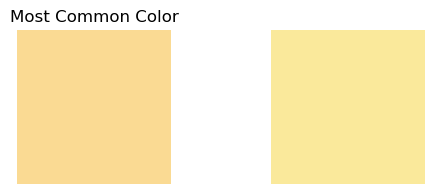

In [9]:
from pathlib import Path
import warnings
import time

warnings.filterwarnings("ignore")
model_weights = Path('osnet_x1_0_market1501.pt')
yolo_model_path = 'runs/detect/6600_Additional_images/weights/best.pt'
input_video_file = "videos/1min_Bodø_start.mp4"
output_video_name = create_new_file(input_video_file.split(".")[0] + "_tracking_output_test.mp4")

print("Tracking output: " + output_video_name)
output_video_file = output_video_name

# home_team_color="white"
# away_team_color="blue"

tracker = initialize_tracker(model_weights)
yolov8 = initialize_yolo(yolo_model_path)

class_names = ["player", "ball"] 

start_time = time.time()
process_video(input_video_file, output_video_file, tracker, yolov8, do_kmeans=True, should_plot=False, class_names=class_names)
end_time = time.time()

execution_time = end_time - start_time

print(f"Time taken to process video: {execution_time} seconds")